In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


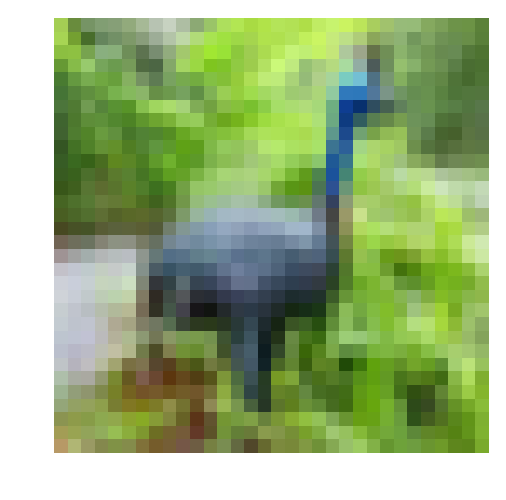

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data

## Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    """
    return (x - np.mean(x)) / np.std(x)
    # return ( x - x.min() ) / ( x.max() - x.min() )

## One hot encode

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    smooth_factor = 0.1
    output = np.zeros([len(x), 10]) # +( smooth_factor / 9 )
    for idx, item in enumerate(x):
        output[idx, item] = 1. #- smooth_factor
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [5]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [6]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features = normalize(valid_features)

# Building the network

## Defining input

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input(n):
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob_"+str(n))


def neural_net_training_flag():
    return tf.placeholder(tf.bool, None, "train_flag")

## Convolution and maxpool layer

In [8]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_train):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    #b = tf.Variable(tf.truncated_normal([conv_num_outputs],
    #                                  mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    # z = tf.nn.bias_add(wc, b)
    z = tf.layers.batch_normalization(wc, training=is_train)
    
    return tf.nn.relu(z)



## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [10]:
def fully_conn(x_tensor, num_outputs, is_train):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    # b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.matmul(fc, w)
    z = tf.layers.batch_normalization(z, training=is_train)
    
    return tf.nn.relu(z)

## Output layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [12]:
def conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4,  train_flag):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv = conv2d(x, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_1)
    with tf.variable_scope("conv2"):
        conv = conv2d(conv, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_1)
    
    with tf.variable_scope("conv3"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_2)
    with tf.variable_scope("conv4"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_2)
    
    with tf.variable_scope("conv5"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv6"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv7"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_3)
    
    with tf.variable_scope("conv8"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv9"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv10"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    with tf.variable_scope("conv11"):
        conv = conv2d(conv, 512, (1, 1), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    
    #with tf.variable_scope("conv11"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.dropout(conv, keep_prob_4)
    #with tf.variable_scope("conv12"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.dropout(conv, keep_prob_4)
    #with tf.variable_scope("conv13"):
    #    conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    #conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    #conv = tf.nn.dropout(conv, keep_prob_4)
    
    
    # Flatten Layer
    f = flatten(conv)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc = fully_conn(f, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    with tf.variable_scope("fc2"):
        fc = fully_conn(fc, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    #with tf.variable_scope("fc3"):
    #    fc = fully_conn(fc, 512, train_flag)
    #    fc = tf.nn.dropout(fc, keep_prob_4)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc, 10)
    
    # TODO: return output
    return o


## Build the network

In [13]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob_1 = neural_net_keep_prob_input(1)
keep_prob_2 = neural_net_keep_prob_input(2)
keep_prob_3 = neural_net_keep_prob_input(3)
keep_prob_4 = neural_net_keep_prob_input(4)
train_flag = neural_net_training_flag()

# Model
logits = conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4, train_flag)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Collect batch mean and variance for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [14]:
def train_neural_network(session, optimizer, kp1, kp2, kp3, kp4, feature_batch, label_batch, is_train):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, 
                                      y: label_batch, 
                                      keep_prob_1: kp1,
                                      keep_prob_2: kp2,
                                      keep_prob_3: kp3,
                                      keep_prob_4: kp4,
                                      train_flag:is_train})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, 
                                        y: label_batch, 
                                        keep_prob_1: 1., 
                                        keep_prob_2: 1.,
                                        keep_prob_3: 1.,
                                        keep_prob_4: 1.,
                                        train_flag:False})
    
    valid_batch_acc_total = 0
    valid_batch_count = 0
        
    for valid_feature_batch, valid_label_batch in helper.batch_features_labels(valid_features, valid_labels, valid_batch_size):
        valid_batch_acc_total += sess.run(accuracy, feed_dict={x: valid_features, 
                                                 y: valid_labels, 
                                                 keep_prob_1: 1., 
                                                 keep_prob_2: 1.,
                                                 keep_prob_3: 1.,
                                                 keep_prob_4: 1.,
                                                 train_flag:False})
                feed_dict={x: valid_feature_batch, y: valid_label_batch, keep_prob: 1.})
        valid_batch_count += 1
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_batch_acc_total/valid_batch_count))

## Hyperparameters

In [16]:
epochs = 2000
batch_size = 64
valid_batch_size = 512
kp1 = 0.8
kp2 = 0.7
kp3 = 0.6
kp4 = 0.5

## Train on a single CIFAR-10 batch

In [17]:
#print('Checking the Training on a Single Batch...')
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
    
    # Training cycle
#    for epoch in range(epochs):
#        batch_i = 1
#        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
#        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#        print_stats(sess, batch_features, batch_labels, cost, accuracy)

## Fully train the model
Deep structure 11 layers, withFliplr, Gaussian Blur, Crop, and Affine, 200 Epochs : 91.1 %

In [18]:
import helper
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

save_model_path = './image_classification'


print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        index = np.array(range(n_batches)) + 1
        np.random.shuffle(index)
        for batch_i in index: # range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                seq = iaa.Sequential([iaa.Fliplr(0.5),
                                      iaa.Flipud(0.2),
                                      sometimes(iaa.Crop(px=2)),
                                      sometimes(iaa.Affine(scale={"X":(0.8,1.2), "y":(0.8,1.2)}, 
                                                           rotate=(-45,45), shear=(-16,16),
                                                           translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                           cval=(0,255), mode=ia.ALL)),
                                      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                                      sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                                      sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))
                                     ], random_order=True)
                batch_features = seq.augment_images(batch_features)
                
                batch_mean = np.mean(batch_features)
                batch_std = np.std(batch_features)
                batch_features = batch_features.astype(np.float32)
                for ii in range(batch_features.shape[0]):
                    batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std                     
                train_neural_network(sess, optimizer, kp1, kp2, kp3, kp4, batch_features, batch_labels, True)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.4488 Validation Accuracy: 0.099800
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.7467 Validation Accuracy: 0.105600
Epoch  1, CIFAR-10 Batch 3:  Loss:     2.2181 Validation Accuracy: 0.181400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.9413 Validation Accuracy: 0.230200
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.3883 Validation Accuracy: 0.246000
Epoch  2, CIFAR-10 Batch 1:  Loss:     2.0844 Validation Accuracy: 0.295600
Epoch  2, CIFAR-10 Batch 2:  Loss:     2.0586 Validation Accuracy: 0.315000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.8147 Validation Accuracy: 0.296200
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.8942 Validation Accuracy: 0.344400
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.0834 Validation Accuracy: 0.353800
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.6686 Validation Accuracy: 0.382600
Epoch  3, CIFAR-10 Batch 4:  Loss:     1.5717 Validation Accuracy: 0.379400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.3199 Validation Accuracy: 0.405800


Epoch 22, CIFAR-10 Batch 4:  Loss:     1.1490 Validation Accuracy: 0.810600
Epoch 22, CIFAR-10 Batch 5:  Loss:     1.1432 Validation Accuracy: 0.813000
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.7779 Validation Accuracy: 0.807600
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.7097 Validation Accuracy: 0.806400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.8907 Validation Accuracy: 0.794800
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.9650 Validation Accuracy: 0.806800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.9742 Validation Accuracy: 0.811400
Epoch 24, CIFAR-10 Batch 3:  Loss:     1.3061 Validation Accuracy: 0.802200
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.8455 Validation Accuracy: 0.795000
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.8079 Validation Accuracy: 0.803400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.7378 Validation Accuracy: 0.806200
Epoch 24, CIFAR-10 Batch 4:  Loss:     1.3304 Validation Accuracy: 0.806800
Epoch 25, CIFAR-10 Batch 2:  Loss:     0.5169 Validation Accuracy: 0.810200
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 1:  Loss:     0.4485 Validation Accuracy: 0.856800
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.9249 Validation Accuracy: 0.852400
Epoch 44, CIFAR-10 Batch 2:  Loss:     0.4980 Validation Accuracy: 0.864200
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.7016 Validation Accuracy: 0.845400
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.5776 Validation Accuracy: 0.849600
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.6450 Validation Accuracy: 0.854600
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.9345 Validation Accuracy: 0.848000
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.5695 Validation Accuracy: 0.848200
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.4240 Validation Accuracy: 0.857000
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.5296 Validation Accuracy: 0.861800
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.6181 Validation Accuracy: 0.846000
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.4870 Validation Accuracy: 0.864000
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.7464 Validation Accuracy: 0.848800
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 3:  Loss:     0.4871 Validation Accuracy: 0.875400
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.5328 Validation Accuracy: 0.876200
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.7556 Validation Accuracy: 0.874000
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.5378 Validation Accuracy: 0.867800
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.6639 Validation Accuracy: 0.877600
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.5435 Validation Accuracy: 0.853400
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.3079 Validation Accuracy: 0.873400
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.5150 Validation Accuracy: 0.879000
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.4978 Validation Accuracy: 0.877600
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.7346 Validation Accuracy: 0.874800
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.7463 Validation Accuracy: 0.876800
Epoch 68, CIFAR-10 Batch 5:  Loss:     0.6420 Validation Accuracy: 0.875800
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.7418 Validation Accuracy: 0.868200
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.5072 Validation Accuracy: 0.875400
Epoch 87, CIFAR-10 Batch 1:  Loss:     1.0191 Validation Accuracy: 0.881400
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.6091 Validation Accuracy: 0.876600
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.3913 Validation Accuracy: 0.893200
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.5766 Validation Accuracy: 0.876200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.4888 Validation Accuracy: 0.883200
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.6775 Validation Accuracy: 0.889000
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.4839 Validation Accuracy: 0.880400
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.4552 Validation Accuracy: 0.885600
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.9359 Validation Accuracy: 0.886200
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.7169 Validation Accuracy: 0.885800
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.3517 Validation Accuracy: 0.889000
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.6637 Validation Accuracy: 0.883200
Epoch 90, CI

Epoch 130, CIFAR-10 Batch 3:  Loss:     0.4168 Validation Accuracy: 0.895200
Epoch 130, CIFAR-10 Batch 2:  Loss:     0.7343 Validation Accuracy: 0.897600
Epoch 130, CIFAR-10 Batch 1:  Loss:     0.6121 Validation Accuracy: 0.902000
Epoch 130, CIFAR-10 Batch 5:  Loss:     0.4826 Validation Accuracy: 0.901400
Epoch 131, CIFAR-10 Batch 3:  Loss:     0.6852 Validation Accuracy: 0.899200
Epoch 131, CIFAR-10 Batch 5:  Loss:     0.2268 Validation Accuracy: 0.890800
Epoch 131, CIFAR-10 Batch 1:  Loss:     0.2551 Validation Accuracy: 0.894000
Epoch 131, CIFAR-10 Batch 2:  Loss:     0.2125 Validation Accuracy: 0.897200
Epoch 131, CIFAR-10 Batch 4:  Loss:     0.6309 Validation Accuracy: 0.902000
Epoch 132, CIFAR-10 Batch 2:  Loss:     0.4250 Validation Accuracy: 0.898000
Epoch 132, CIFAR-10 Batch 5:  Loss:     0.4313 Validation Accuracy: 0.899600
Epoch 132, CIFAR-10 Batch 1:  Loss:     0.3604 Validation Accuracy: 0.895000
Epoch 132, CIFAR-10 Batch 3:  Loss:     0.5196 Validation Accuracy: 0.897200

Epoch 151, CIFAR-10 Batch 5:  Loss:     0.3020 Validation Accuracy: 0.903200
Epoch 151, CIFAR-10 Batch 4:  Loss:     0.6802 Validation Accuracy: 0.907000
Epoch 152, CIFAR-10 Batch 2:  Loss:     0.5067 Validation Accuracy: 0.900600
Epoch 152, CIFAR-10 Batch 4:  Loss:     0.3514 Validation Accuracy: 0.907000
Epoch 152, CIFAR-10 Batch 1:  Loss:     0.3787 Validation Accuracy: 0.903000
Epoch 152, CIFAR-10 Batch 3:  Loss:     0.3461 Validation Accuracy: 0.901000
Epoch 152, CIFAR-10 Batch 5:  Loss:     0.3545 Validation Accuracy: 0.906800
Epoch 153, CIFAR-10 Batch 1:  Loss:     0.2093 Validation Accuracy: 0.906800
Epoch 153, CIFAR-10 Batch 3:  Loss:     0.3045 Validation Accuracy: 0.904800
Epoch 153, CIFAR-10 Batch 2:  Loss:     0.6737 Validation Accuracy: 0.902600
Epoch 153, CIFAR-10 Batch 5:  Loss:     0.5785 Validation Accuracy: 0.903800
Epoch 153, CIFAR-10 Batch 4:  Loss:     0.7290 Validation Accuracy: 0.898600
Epoch 154, CIFAR-10 Batch 4:  Loss:     0.4685 Validation Accuracy: 0.905000

Epoch 173, CIFAR-10 Batch 2:  Loss:     0.4331 Validation Accuracy: 0.904800
Epoch 173, CIFAR-10 Batch 5:  Loss:     0.2490 Validation Accuracy: 0.906800
Epoch 173, CIFAR-10 Batch 1:  Loss:     0.5182 Validation Accuracy: 0.903400
Epoch 173, CIFAR-10 Batch 4:  Loss:     0.2712 Validation Accuracy: 0.908800
Epoch 173, CIFAR-10 Batch 3:  Loss:     0.3875 Validation Accuracy: 0.909600
Epoch 174, CIFAR-10 Batch 2:  Loss:     0.1628 Validation Accuracy: 0.903600
Epoch 174, CIFAR-10 Batch 3:  Loss:     0.3738 Validation Accuracy: 0.904200
Epoch 174, CIFAR-10 Batch 4:  Loss:     0.5253 Validation Accuracy: 0.905000
Epoch 174, CIFAR-10 Batch 1:  Loss:     0.3549 Validation Accuracy: 0.904800
Epoch 174, CIFAR-10 Batch 5:  Loss:     0.4122 Validation Accuracy: 0.908000
Epoch 175, CIFAR-10 Batch 5:  Loss:     0.7127 Validation Accuracy: 0.908600
Epoch 175, CIFAR-10 Batch 3:  Loss:     0.3592 Validation Accuracy: 0.904800
Epoch 175, CIFAR-10 Batch 2:  Loss:     0.4062 Validation Accuracy: 0.903000

Epoch 194, CIFAR-10 Batch 5:  Loss:     0.3323 Validation Accuracy: 0.908600
Epoch 194, CIFAR-10 Batch 3:  Loss:     0.1714 Validation Accuracy: 0.911800
Epoch 194, CIFAR-10 Batch 1:  Loss:     0.2182 Validation Accuracy: 0.908200
Epoch 195, CIFAR-10 Batch 1:  Loss:     0.1961 Validation Accuracy: 0.911400
Epoch 195, CIFAR-10 Batch 5:  Loss:     0.4250 Validation Accuracy: 0.913800
Epoch 195, CIFAR-10 Batch 4:  Loss:     0.4159 Validation Accuracy: 0.906800
Epoch 195, CIFAR-10 Batch 2:  Loss:     0.2475 Validation Accuracy: 0.915600
Epoch 195, CIFAR-10 Batch 3:  Loss:     0.3684 Validation Accuracy: 0.908000
Epoch 196, CIFAR-10 Batch 2:  Loss:     0.6073 Validation Accuracy: 0.911800
Epoch 196, CIFAR-10 Batch 1:  Loss:     0.4380 Validation Accuracy: 0.907800
Epoch 196, CIFAR-10 Batch 5:  Loss:     0.3182 Validation Accuracy: 0.911200
Epoch 196, CIFAR-10 Batch 3:  Loss:     0.5091 Validation Accuracy: 0.915600
Epoch 196, CIFAR-10 Batch 4:  Loss:     0.5798 Validation Accuracy: 0.912400

Epoch 215, CIFAR-10 Batch 3:  Loss:     0.3353 Validation Accuracy: 0.909200
Epoch 216, CIFAR-10 Batch 1:  Loss:     0.4109 Validation Accuracy: 0.914400
Epoch 216, CIFAR-10 Batch 4:  Loss:     0.5513 Validation Accuracy: 0.905200
Epoch 216, CIFAR-10 Batch 5:  Loss:     0.6270 Validation Accuracy: 0.911800
Epoch 216, CIFAR-10 Batch 2:  Loss:     0.3181 Validation Accuracy: 0.912400
Epoch 216, CIFAR-10 Batch 3:  Loss:     0.2670 Validation Accuracy: 0.911800
Epoch 217, CIFAR-10 Batch 3:  Loss:     0.4884 Validation Accuracy: 0.907000
Epoch 217, CIFAR-10 Batch 5:  Loss:     0.2110 Validation Accuracy: 0.906600
Epoch 217, CIFAR-10 Batch 2:  Loss:     0.4069 Validation Accuracy: 0.911200
Epoch 217, CIFAR-10 Batch 1:  Loss:     0.5882 Validation Accuracy: 0.909400
Epoch 217, CIFAR-10 Batch 4:  Loss:     0.5487 Validation Accuracy: 0.911200
Epoch 218, CIFAR-10 Batch 3:  Loss:     0.2447 Validation Accuracy: 0.913200
Epoch 218, CIFAR-10 Batch 1:  Loss:     0.4753 Validation Accuracy: 0.910200

Epoch 237, CIFAR-10 Batch 3:  Loss:     0.6706 Validation Accuracy: 0.913200
Epoch 237, CIFAR-10 Batch 5:  Loss:     0.5624 Validation Accuracy: 0.914800
Epoch 237, CIFAR-10 Batch 2:  Loss:     0.4988 Validation Accuracy: 0.913200
Epoch 237, CIFAR-10 Batch 4:  Loss:     0.4505 Validation Accuracy: 0.915800
Epoch 238, CIFAR-10 Batch 2:  Loss:     0.3984 Validation Accuracy: 0.917600
Epoch 238, CIFAR-10 Batch 3:  Loss:     0.5341 Validation Accuracy: 0.910800
Epoch 238, CIFAR-10 Batch 5:  Loss:     0.6691 Validation Accuracy: 0.914400
Epoch 238, CIFAR-10 Batch 4:  Loss:     0.6074 Validation Accuracy: 0.912000
Epoch 238, CIFAR-10 Batch 1:  Loss:     0.3644 Validation Accuracy: 0.910600
Epoch 239, CIFAR-10 Batch 2:  Loss:     0.2274 Validation Accuracy: 0.913400
Epoch 239, CIFAR-10 Batch 5:  Loss:     0.2521 Validation Accuracy: 0.907000
Epoch 239, CIFAR-10 Batch 3:  Loss:     0.5448 Validation Accuracy: 0.909800
Epoch 239, CIFAR-10 Batch 4:  Loss:     0.4789 Validation Accuracy: 0.910600

Epoch 258, CIFAR-10 Batch 1:  Loss:     0.3688 Validation Accuracy: 0.913000
Epoch 258, CIFAR-10 Batch 5:  Loss:     0.2968 Validation Accuracy: 0.912800
Epoch 259, CIFAR-10 Batch 4:  Loss:     0.5000 Validation Accuracy: 0.919600
Epoch 259, CIFAR-10 Batch 2:  Loss:     0.3450 Validation Accuracy: 0.916200
Epoch 259, CIFAR-10 Batch 5:  Loss:     0.4328 Validation Accuracy: 0.911600
Epoch 259, CIFAR-10 Batch 1:  Loss:     0.5191 Validation Accuracy: 0.913800
Epoch 259, CIFAR-10 Batch 3:  Loss:     0.3033 Validation Accuracy: 0.912400
Epoch 260, CIFAR-10 Batch 5:  Loss:     0.4478 Validation Accuracy: 0.915800
Epoch 260, CIFAR-10 Batch 4:  Loss:     0.2858 Validation Accuracy: 0.914600
Epoch 260, CIFAR-10 Batch 2:  Loss:     0.3129 Validation Accuracy: 0.915800
Epoch 260, CIFAR-10 Batch 3:  Loss:     0.3017 Validation Accuracy: 0.915000
Epoch 260, CIFAR-10 Batch 1:  Loss:     0.3081 Validation Accuracy: 0.911800
Epoch 261, CIFAR-10 Batch 4:  Loss:     0.3158 Validation Accuracy: 0.912000

Epoch 280, CIFAR-10 Batch 3:  Loss:     0.3660 Validation Accuracy: 0.918200
Epoch 280, CIFAR-10 Batch 5:  Loss:     0.3258 Validation Accuracy: 0.916200
Epoch 280, CIFAR-10 Batch 4:  Loss:     0.2772 Validation Accuracy: 0.916800
Epoch 280, CIFAR-10 Batch 2:  Loss:     0.3439 Validation Accuracy: 0.919000
Epoch 280, CIFAR-10 Batch 1:  Loss:     0.5793 Validation Accuracy: 0.917200
Epoch 281, CIFAR-10 Batch 1:  Loss:     0.2034 Validation Accuracy: 0.915200
Epoch 281, CIFAR-10 Batch 5:  Loss:     0.7172 Validation Accuracy: 0.915600
Epoch 281, CIFAR-10 Batch 2:  Loss:     0.2006 Validation Accuracy: 0.913400
Epoch 281, CIFAR-10 Batch 4:  Loss:     0.4135 Validation Accuracy: 0.914000
Epoch 281, CIFAR-10 Batch 3:  Loss:     0.5461 Validation Accuracy: 0.912600
Epoch 282, CIFAR-10 Batch 5:  Loss:     0.5964 Validation Accuracy: 0.913000
Epoch 282, CIFAR-10 Batch 1:  Loss:     0.2411 Validation Accuracy: 0.912400
Epoch 282, CIFAR-10 Batch 2:  Loss:     0.3610 Validation Accuracy: 0.914200

Epoch 301, CIFAR-10 Batch 3:  Loss:     0.3411 Validation Accuracy: 0.913600
Epoch 301, CIFAR-10 Batch 5:  Loss:     0.4535 Validation Accuracy: 0.912200
Epoch 301, CIFAR-10 Batch 4:  Loss:     0.2101 Validation Accuracy: 0.916800
Epoch 302, CIFAR-10 Batch 1:  Loss:     0.3092 Validation Accuracy: 0.914000
Epoch 302, CIFAR-10 Batch 5:  Loss:     0.2900 Validation Accuracy: 0.917600
Epoch 302, CIFAR-10 Batch 3:  Loss:     0.3295 Validation Accuracy: 0.912200
Epoch 302, CIFAR-10 Batch 2:  Loss:     0.2789 Validation Accuracy: 0.916200
Epoch 302, CIFAR-10 Batch 4:  Loss:     0.5485 Validation Accuracy: 0.912400
Epoch 303, CIFAR-10 Batch 5:  Loss:     0.3860 Validation Accuracy: 0.913800
Epoch 303, CIFAR-10 Batch 4:  Loss:     0.3039 Validation Accuracy: 0.915400
Epoch 303, CIFAR-10 Batch 1:  Loss:     0.5265 Validation Accuracy: 0.912200
Epoch 303, CIFAR-10 Batch 3:  Loss:     0.5191 Validation Accuracy: 0.914800
Epoch 303, CIFAR-10 Batch 2:  Loss:     0.4412 Validation Accuracy: 0.913200

Epoch 322, CIFAR-10 Batch 1:  Loss:     0.3240 Validation Accuracy: 0.920200
Epoch 323, CIFAR-10 Batch 5:  Loss:     0.2066 Validation Accuracy: 0.921200
Epoch 323, CIFAR-10 Batch 3:  Loss:     0.4410 Validation Accuracy: 0.916600
Epoch 323, CIFAR-10 Batch 1:  Loss:     0.4067 Validation Accuracy: 0.919400
Epoch 323, CIFAR-10 Batch 2:  Loss:     0.1978 Validation Accuracy: 0.919400
Epoch 323, CIFAR-10 Batch 4:  Loss:     0.1718 Validation Accuracy: 0.922000
Epoch 324, CIFAR-10 Batch 4:  Loss:     0.1562 Validation Accuracy: 0.919600
Epoch 324, CIFAR-10 Batch 2:  Loss:     0.3326 Validation Accuracy: 0.917600
Epoch 324, CIFAR-10 Batch 5:  Loss:     0.3554 Validation Accuracy: 0.919600
Epoch 324, CIFAR-10 Batch 3:  Loss:     0.3860 Validation Accuracy: 0.915600
Epoch 324, CIFAR-10 Batch 1:  Loss:     0.5629 Validation Accuracy: 0.913600
Epoch 325, CIFAR-10 Batch 5:  Loss:     0.5948 Validation Accuracy: 0.921600
Epoch 325, CIFAR-10 Batch 3:  Loss:     0.1458 Validation Accuracy: 0.912600

Epoch 344, CIFAR-10 Batch 5:  Loss:     0.5048 Validation Accuracy: 0.916600
Epoch 344, CIFAR-10 Batch 1:  Loss:     0.1157 Validation Accuracy: 0.915800
Epoch 344, CIFAR-10 Batch 2:  Loss:     0.3057 Validation Accuracy: 0.917800
Epoch 344, CIFAR-10 Batch 4:  Loss:     0.5005 Validation Accuracy: 0.919800
Epoch 345, CIFAR-10 Batch 2:  Loss:     0.5703 Validation Accuracy: 0.915600
Epoch 345, CIFAR-10 Batch 1:  Loss:     0.7819 Validation Accuracy: 0.921200
Epoch 345, CIFAR-10 Batch 3:  Loss:     0.5432 Validation Accuracy: 0.918200
Epoch 345, CIFAR-10 Batch 4:  Loss:     0.4625 Validation Accuracy: 0.912600
Epoch 345, CIFAR-10 Batch 5:  Loss:     0.4484 Validation Accuracy: 0.914800
Epoch 346, CIFAR-10 Batch 2:  Loss:     0.6934 Validation Accuracy: 0.918000
Epoch 346, CIFAR-10 Batch 5:  Loss:     0.4813 Validation Accuracy: 0.915000
Epoch 346, CIFAR-10 Batch 3:  Loss:     0.3434 Validation Accuracy: 0.917000
Epoch 346, CIFAR-10 Batch 4:  Loss:     0.5394 Validation Accuracy: 0.914400

Epoch 365, CIFAR-10 Batch 2:  Loss:     0.5533 Validation Accuracy: 0.919000
Epoch 365, CIFAR-10 Batch 1:  Loss:     0.5481 Validation Accuracy: 0.921400
Epoch 366, CIFAR-10 Batch 4:  Loss:     0.1913 Validation Accuracy: 0.917600
Epoch 366, CIFAR-10 Batch 1:  Loss:     0.2606 Validation Accuracy: 0.921400
Epoch 366, CIFAR-10 Batch 2:  Loss:     0.4951 Validation Accuracy: 0.921600
Epoch 366, CIFAR-10 Batch 5:  Loss:     0.4627 Validation Accuracy: 0.916600
Epoch 366, CIFAR-10 Batch 3:  Loss:     0.2297 Validation Accuracy: 0.919200
Epoch 367, CIFAR-10 Batch 3:  Loss:     0.5724 Validation Accuracy: 0.918600
Epoch 367, CIFAR-10 Batch 2:  Loss:     0.4372 Validation Accuracy: 0.921000
Epoch 367, CIFAR-10 Batch 1:  Loss:     0.1350 Validation Accuracy: 0.917600
Epoch 367, CIFAR-10 Batch 5:  Loss:     0.3855 Validation Accuracy: 0.919800
Epoch 367, CIFAR-10 Batch 4:  Loss:     0.4365 Validation Accuracy: 0.918400
Epoch 368, CIFAR-10 Batch 3:  Loss:     0.2231 Validation Accuracy: 0.919600

Epoch 387, CIFAR-10 Batch 3:  Loss:     0.3722 Validation Accuracy: 0.916600
Epoch 387, CIFAR-10 Batch 4:  Loss:     0.3640 Validation Accuracy: 0.922400
Epoch 387, CIFAR-10 Batch 2:  Loss:     0.4194 Validation Accuracy: 0.917800
Epoch 387, CIFAR-10 Batch 5:  Loss:     0.2074 Validation Accuracy: 0.917800
Epoch 387, CIFAR-10 Batch 1:  Loss:     0.3503 Validation Accuracy: 0.917600
Epoch 388, CIFAR-10 Batch 4:  Loss:     0.2676 Validation Accuracy: 0.916800
Epoch 388, CIFAR-10 Batch 2:  Loss:     0.2288 Validation Accuracy: 0.915200
Epoch 388, CIFAR-10 Batch 1:  Loss:     0.3968 Validation Accuracy: 0.922400
Epoch 388, CIFAR-10 Batch 3:  Loss:     0.5728 Validation Accuracy: 0.918400
Epoch 388, CIFAR-10 Batch 5:  Loss:     0.3119 Validation Accuracy: 0.921600
Epoch 389, CIFAR-10 Batch 5:  Loss:     0.2049 Validation Accuracy: 0.920600
Epoch 389, CIFAR-10 Batch 4:  Loss:     0.3431 Validation Accuracy: 0.923600
Epoch 389, CIFAR-10 Batch 2:  Loss:     0.3716 Validation Accuracy: 0.918600

Epoch 408, CIFAR-10 Batch 1:  Loss:     0.1734 Validation Accuracy: 0.919400
Epoch 408, CIFAR-10 Batch 2:  Loss:     0.2979 Validation Accuracy: 0.918000
Epoch 408, CIFAR-10 Batch 3:  Loss:     0.2207 Validation Accuracy: 0.918600
Epoch 409, CIFAR-10 Batch 4:  Loss:     0.1516 Validation Accuracy: 0.917200
Epoch 409, CIFAR-10 Batch 3:  Loss:     0.2757 Validation Accuracy: 0.919800
Epoch 409, CIFAR-10 Batch 2:  Loss:     0.4000 Validation Accuracy: 0.918400
Epoch 409, CIFAR-10 Batch 5:  Loss:     0.1496 Validation Accuracy: 0.922000
Epoch 409, CIFAR-10 Batch 1:  Loss:     0.3170 Validation Accuracy: 0.920400
Epoch 410, CIFAR-10 Batch 5:  Loss:     0.2052 Validation Accuracy: 0.917200
Epoch 410, CIFAR-10 Batch 1:  Loss:     0.0892 Validation Accuracy: 0.917800
Epoch 410, CIFAR-10 Batch 4:  Loss:     0.4334 Validation Accuracy: 0.917800
Epoch 410, CIFAR-10 Batch 2:  Loss:     0.5021 Validation Accuracy: 0.921400
Epoch 410, CIFAR-10 Batch 3:  Loss:     0.2748 Validation Accuracy: 0.919200

Epoch 429, CIFAR-10 Batch 2:  Loss:     0.3431 Validation Accuracy: 0.920600
Epoch 430, CIFAR-10 Batch 4:  Loss:     0.5300 Validation Accuracy: 0.922000
Epoch 430, CIFAR-10 Batch 3:  Loss:     0.3678 Validation Accuracy: 0.918200
Epoch 430, CIFAR-10 Batch 5:  Loss:     0.6447 Validation Accuracy: 0.918000
Epoch 430, CIFAR-10 Batch 1:  Loss:     0.3542 Validation Accuracy: 0.919200
Epoch 430, CIFAR-10 Batch 2:  Loss:     0.1558 Validation Accuracy: 0.923400
Epoch 431, CIFAR-10 Batch 5:  Loss:     0.5217 Validation Accuracy: 0.923600
Epoch 431, CIFAR-10 Batch 2:  Loss:     0.3184 Validation Accuracy: 0.920800
Epoch 431, CIFAR-10 Batch 1:  Loss:     0.2471 Validation Accuracy: 0.919000
Epoch 431, CIFAR-10 Batch 4:  Loss:     0.1380 Validation Accuracy: 0.918400
Epoch 431, CIFAR-10 Batch 3:  Loss:     0.5310 Validation Accuracy: 0.920800
Epoch 432, CIFAR-10 Batch 3:  Loss:     0.3555 Validation Accuracy: 0.920000
Epoch 432, CIFAR-10 Batch 4:  Loss:     0.3750 Validation Accuracy: 0.918600

Epoch 451, CIFAR-10 Batch 5:  Loss:     0.2333 Validation Accuracy: 0.924800
Epoch 451, CIFAR-10 Batch 2:  Loss:     0.1209 Validation Accuracy: 0.921200
Epoch 451, CIFAR-10 Batch 4:  Loss:     0.3096 Validation Accuracy: 0.920200
Epoch 451, CIFAR-10 Batch 3:  Loss:     0.4123 Validation Accuracy: 0.923400
Epoch 452, CIFAR-10 Batch 3:  Loss:     0.3236 Validation Accuracy: 0.920800
Epoch 452, CIFAR-10 Batch 4:  Loss:     0.3721 Validation Accuracy: 0.917000
Epoch 452, CIFAR-10 Batch 1:  Loss:     0.4534 Validation Accuracy: 0.918800
Epoch 452, CIFAR-10 Batch 5:  Loss:     0.4031 Validation Accuracy: 0.924200
Epoch 452, CIFAR-10 Batch 2:  Loss:     0.3499 Validation Accuracy: 0.920600
Epoch 453, CIFAR-10 Batch 1:  Loss:     0.2961 Validation Accuracy: 0.921200
Epoch 453, CIFAR-10 Batch 5:  Loss:     0.2049 Validation Accuracy: 0.918800
Epoch 453, CIFAR-10 Batch 2:  Loss:     0.3623 Validation Accuracy: 0.918200
Epoch 453, CIFAR-10 Batch 4:  Loss:     0.4307 Validation Accuracy: 0.921400

Epoch 472, CIFAR-10 Batch 4:  Loss:     0.2383 Validation Accuracy: 0.923800
Epoch 472, CIFAR-10 Batch 3:  Loss:     0.6795 Validation Accuracy: 0.922600
Epoch 473, CIFAR-10 Batch 2:  Loss:     0.2891 Validation Accuracy: 0.924000
Epoch 473, CIFAR-10 Batch 1:  Loss:     0.1617 Validation Accuracy: 0.923200
Epoch 473, CIFAR-10 Batch 3:  Loss:     0.3328 Validation Accuracy: 0.923800
Epoch 473, CIFAR-10 Batch 4:  Loss:     0.6300 Validation Accuracy: 0.923400
Epoch 473, CIFAR-10 Batch 5:  Loss:     0.5565 Validation Accuracy: 0.923600
Epoch 474, CIFAR-10 Batch 3:  Loss:     0.2981 Validation Accuracy: 0.922000
Epoch 474, CIFAR-10 Batch 2:  Loss:     0.1380 Validation Accuracy: 0.923000
Epoch 474, CIFAR-10 Batch 1:  Loss:     0.2856 Validation Accuracy: 0.923200
Epoch 474, CIFAR-10 Batch 4:  Loss:     0.4688 Validation Accuracy: 0.922600
Epoch 474, CIFAR-10 Batch 5:  Loss:     0.4572 Validation Accuracy: 0.922200
Epoch 475, CIFAR-10 Batch 2:  Loss:     0.2306 Validation Accuracy: 0.920600

Epoch 494, CIFAR-10 Batch 5:  Loss:     0.2715 Validation Accuracy: 0.921200
Epoch 494, CIFAR-10 Batch 3:  Loss:     0.3702 Validation Accuracy: 0.925600
Epoch 494, CIFAR-10 Batch 4:  Loss:     0.1845 Validation Accuracy: 0.924200
Epoch 494, CIFAR-10 Batch 1:  Loss:     0.3626 Validation Accuracy: 0.924600
Epoch 494, CIFAR-10 Batch 2:  Loss:     0.1624 Validation Accuracy: 0.924600
Epoch 495, CIFAR-10 Batch 2:  Loss:     0.2679 Validation Accuracy: 0.925000
Epoch 495, CIFAR-10 Batch 3:  Loss:     0.2413 Validation Accuracy: 0.926000
Epoch 495, CIFAR-10 Batch 4:  Loss:     0.3977 Validation Accuracy: 0.918400
Epoch 495, CIFAR-10 Batch 5:  Loss:     0.4088 Validation Accuracy: 0.922800
Epoch 495, CIFAR-10 Batch 1:  Loss:     0.2772 Validation Accuracy: 0.924000
Epoch 496, CIFAR-10 Batch 1:  Loss:     0.1807 Validation Accuracy: 0.920400
Epoch 496, CIFAR-10 Batch 5:  Loss:     0.1891 Validation Accuracy: 0.923600
Epoch 496, CIFAR-10 Batch 3:  Loss:     0.2105 Validation Accuracy: 0.923600

Epoch 515, CIFAR-10 Batch 5:  Loss:     0.2978 Validation Accuracy: 0.923400
Epoch 515, CIFAR-10 Batch 1:  Loss:     0.1987 Validation Accuracy: 0.926000
Epoch 515, CIFAR-10 Batch 4:  Loss:     0.3310 Validation Accuracy: 0.926200
Epoch 516, CIFAR-10 Batch 4:  Loss:     0.3182 Validation Accuracy: 0.923600
Epoch 516, CIFAR-10 Batch 1:  Loss:     0.2842 Validation Accuracy: 0.924800
Epoch 516, CIFAR-10 Batch 3:  Loss:     0.6127 Validation Accuracy: 0.920800
Epoch 516, CIFAR-10 Batch 2:  Loss:     0.2358 Validation Accuracy: 0.918000
Epoch 516, CIFAR-10 Batch 5:  Loss:     0.4486 Validation Accuracy: 0.924800
Epoch 517, CIFAR-10 Batch 3:  Loss:     0.3383 Validation Accuracy: 0.918400
Epoch 517, CIFAR-10 Batch 1:  Loss:     0.4750 Validation Accuracy: 0.925400
Epoch 517, CIFAR-10 Batch 5:  Loss:     0.1553 Validation Accuracy: 0.925400
Epoch 517, CIFAR-10 Batch 2:  Loss:     0.3215 Validation Accuracy: 0.923000
Epoch 517, CIFAR-10 Batch 4:  Loss:     0.2665 Validation Accuracy: 0.926000

Epoch 536, CIFAR-10 Batch 3:  Loss:     0.1137 Validation Accuracy: 0.926600
Epoch 537, CIFAR-10 Batch 2:  Loss:     0.3108 Validation Accuracy: 0.927400
Epoch 537, CIFAR-10 Batch 3:  Loss:     0.3234 Validation Accuracy: 0.922000
Epoch 537, CIFAR-10 Batch 5:  Loss:     0.2501 Validation Accuracy: 0.924200
Epoch 537, CIFAR-10 Batch 4:  Loss:     0.2865 Validation Accuracy: 0.922000
Epoch 537, CIFAR-10 Batch 1:  Loss:     0.1959 Validation Accuracy: 0.925800
Epoch 538, CIFAR-10 Batch 4:  Loss:     0.2167 Validation Accuracy: 0.923000
Epoch 538, CIFAR-10 Batch 5:  Loss:     0.3013 Validation Accuracy: 0.922000
Epoch 538, CIFAR-10 Batch 3:  Loss:     0.3353 Validation Accuracy: 0.927800
Epoch 538, CIFAR-10 Batch 2:  Loss:     0.1756 Validation Accuracy: 0.921600
Epoch 538, CIFAR-10 Batch 1:  Loss:     0.3937 Validation Accuracy: 0.926400
Epoch 539, CIFAR-10 Batch 5:  Loss:     0.4650 Validation Accuracy: 0.924200
Epoch 539, CIFAR-10 Batch 3:  Loss:     0.3875 Validation Accuracy: 0.923800

Epoch 558, CIFAR-10 Batch 5:  Loss:     0.2096 Validation Accuracy: 0.924000
Epoch 558, CIFAR-10 Batch 3:  Loss:     0.2342 Validation Accuracy: 0.924000
Epoch 558, CIFAR-10 Batch 1:  Loss:     0.1551 Validation Accuracy: 0.922200
Epoch 558, CIFAR-10 Batch 4:  Loss:     0.4568 Validation Accuracy: 0.926000
Epoch 559, CIFAR-10 Batch 2:  Loss:     0.4037 Validation Accuracy: 0.924800
Epoch 559, CIFAR-10 Batch 1:  Loss:     0.2055 Validation Accuracy: 0.923400
Epoch 559, CIFAR-10 Batch 5:  Loss:     0.1066 Validation Accuracy: 0.926600
Epoch 559, CIFAR-10 Batch 3:  Loss:     0.2911 Validation Accuracy: 0.926200
Epoch 559, CIFAR-10 Batch 4:  Loss:     0.1523 Validation Accuracy: 0.926400
Epoch 560, CIFAR-10 Batch 4:  Loss:     0.3592 Validation Accuracy: 0.926000
Epoch 560, CIFAR-10 Batch 3:  Loss:     0.2097 Validation Accuracy: 0.925400
Epoch 560, CIFAR-10 Batch 5:  Loss:     0.5417 Validation Accuracy: 0.925800
Epoch 560, CIFAR-10 Batch 2:  Loss:     0.4749 Validation Accuracy: 0.925400

Epoch 579, CIFAR-10 Batch 3:  Loss:     0.5557 Validation Accuracy: 0.923200
Epoch 579, CIFAR-10 Batch 5:  Loss:     0.3401 Validation Accuracy: 0.928000
Epoch 580, CIFAR-10 Batch 3:  Loss:     0.1622 Validation Accuracy: 0.922000
Epoch 580, CIFAR-10 Batch 1:  Loss:     0.3446 Validation Accuracy: 0.925000
Epoch 580, CIFAR-10 Batch 4:  Loss:     0.4988 Validation Accuracy: 0.926200
Epoch 580, CIFAR-10 Batch 2:  Loss:     0.2734 Validation Accuracy: 0.923000
Epoch 580, CIFAR-10 Batch 5:  Loss:     0.2930 Validation Accuracy: 0.924600
Epoch 581, CIFAR-10 Batch 4:  Loss:     0.2016 Validation Accuracy: 0.922200
Epoch 581, CIFAR-10 Batch 5:  Loss:     0.3026 Validation Accuracy: 0.925400
Epoch 581, CIFAR-10 Batch 2:  Loss:     0.4488 Validation Accuracy: 0.925800
Epoch 581, CIFAR-10 Batch 3:  Loss:     0.4179 Validation Accuracy: 0.924400
Epoch 581, CIFAR-10 Batch 1:  Loss:     0.3074 Validation Accuracy: 0.925000
Epoch 582, CIFAR-10 Batch 5:  Loss:     0.3650 Validation Accuracy: 0.924800

Epoch 601, CIFAR-10 Batch 4:  Loss:     0.2746 Validation Accuracy: 0.926400
Epoch 601, CIFAR-10 Batch 5:  Loss:     0.3130 Validation Accuracy: 0.925200
Epoch 601, CIFAR-10 Batch 1:  Loss:     0.1450 Validation Accuracy: 0.927800
Epoch 601, CIFAR-10 Batch 3:  Loss:     0.2488 Validation Accuracy: 0.927800
Epoch 601, CIFAR-10 Batch 2:  Loss:     0.2147 Validation Accuracy: 0.926000
Epoch 602, CIFAR-10 Batch 5:  Loss:     0.3051 Validation Accuracy: 0.923800
Epoch 602, CIFAR-10 Batch 2:  Loss:     0.5693 Validation Accuracy: 0.928200
Epoch 602, CIFAR-10 Batch 1:  Loss:     0.1997 Validation Accuracy: 0.925200
Epoch 602, CIFAR-10 Batch 3:  Loss:     0.3345 Validation Accuracy: 0.926400
Epoch 602, CIFAR-10 Batch 4:  Loss:     0.2176 Validation Accuracy: 0.924600
Epoch 603, CIFAR-10 Batch 5:  Loss:     0.4934 Validation Accuracy: 0.927800
Epoch 603, CIFAR-10 Batch 2:  Loss:     0.4616 Validation Accuracy: 0.925000
Epoch 603, CIFAR-10 Batch 4:  Loss:     0.4618 Validation Accuracy: 0.927000

Epoch 622, CIFAR-10 Batch 4:  Loss:     0.3189 Validation Accuracy: 0.928200
Epoch 622, CIFAR-10 Batch 5:  Loss:     0.3179 Validation Accuracy: 0.926000
Epoch 622, CIFAR-10 Batch 1:  Loss:     0.2653 Validation Accuracy: 0.926000
Epoch 623, CIFAR-10 Batch 1:  Loss:     0.1238 Validation Accuracy: 0.928000
Epoch 623, CIFAR-10 Batch 3:  Loss:     0.2357 Validation Accuracy: 0.928200
Epoch 623, CIFAR-10 Batch 4:  Loss:     0.4598 Validation Accuracy: 0.927600
Epoch 623, CIFAR-10 Batch 2:  Loss:     0.3949 Validation Accuracy: 0.925400
Epoch 623, CIFAR-10 Batch 5:  Loss:     0.3054 Validation Accuracy: 0.931800
Epoch 624, CIFAR-10 Batch 5:  Loss:     0.3013 Validation Accuracy: 0.927600
Epoch 624, CIFAR-10 Batch 1:  Loss:     0.5282 Validation Accuracy: 0.927800
Epoch 624, CIFAR-10 Batch 4:  Loss:     0.2730 Validation Accuracy: 0.928000
Epoch 624, CIFAR-10 Batch 3:  Loss:     0.4147 Validation Accuracy: 0.927200
Epoch 624, CIFAR-10 Batch 2:  Loss:     0.2131 Validation Accuracy: 0.925400

Epoch 643, CIFAR-10 Batch 2:  Loss:     0.3471 Validation Accuracy: 0.926600
Epoch 644, CIFAR-10 Batch 2:  Loss:     0.1607 Validation Accuracy: 0.925600
Epoch 644, CIFAR-10 Batch 4:  Loss:     0.3332 Validation Accuracy: 0.924800
Epoch 644, CIFAR-10 Batch 1:  Loss:     0.2176 Validation Accuracy: 0.922000
Epoch 644, CIFAR-10 Batch 3:  Loss:     0.4277 Validation Accuracy: 0.925600
Epoch 644, CIFAR-10 Batch 5:  Loss:     0.1407 Validation Accuracy: 0.930000
Epoch 645, CIFAR-10 Batch 3:  Loss:     0.4153 Validation Accuracy: 0.923600
Epoch 645, CIFAR-10 Batch 4:  Loss:     0.2364 Validation Accuracy: 0.925800
Epoch 645, CIFAR-10 Batch 5:  Loss:     0.3221 Validation Accuracy: 0.926600
Epoch 645, CIFAR-10 Batch 1:  Loss:     0.3840 Validation Accuracy: 0.928000
Epoch 645, CIFAR-10 Batch 2:  Loss:     0.2170 Validation Accuracy: 0.925600
Epoch 646, CIFAR-10 Batch 2:  Loss:     0.3046 Validation Accuracy: 0.924000
Epoch 646, CIFAR-10 Batch 1:  Loss:     0.3995 Validation Accuracy: 0.921400

Epoch 665, CIFAR-10 Batch 5:  Loss:     0.4397 Validation Accuracy: 0.929600
Epoch 665, CIFAR-10 Batch 2:  Loss:     0.2562 Validation Accuracy: 0.926400
Epoch 665, CIFAR-10 Batch 3:  Loss:     0.3586 Validation Accuracy: 0.928400
Epoch 665, CIFAR-10 Batch 4:  Loss:     0.4758 Validation Accuracy: 0.928400
Epoch 666, CIFAR-10 Batch 2:  Loss:     0.4890 Validation Accuracy: 0.925800
Epoch 666, CIFAR-10 Batch 1:  Loss:     0.6086 Validation Accuracy: 0.925400
Epoch 666, CIFAR-10 Batch 4:  Loss:     0.1819 Validation Accuracy: 0.927200
Epoch 666, CIFAR-10 Batch 5:  Loss:     0.3419 Validation Accuracy: 0.925800
Epoch 666, CIFAR-10 Batch 3:  Loss:     0.3217 Validation Accuracy: 0.927400
Epoch 667, CIFAR-10 Batch 3:  Loss:     0.1312 Validation Accuracy: 0.929400
Epoch 667, CIFAR-10 Batch 1:  Loss:     0.1456 Validation Accuracy: 0.926400
Epoch 667, CIFAR-10 Batch 2:  Loss:     0.2368 Validation Accuracy: 0.929200
Epoch 667, CIFAR-10 Batch 5:  Loss:     0.2374 Validation Accuracy: 0.927000

Epoch 686, CIFAR-10 Batch 1:  Loss:     0.2965 Validation Accuracy: 0.926400
Epoch 686, CIFAR-10 Batch 4:  Loss:     0.5945 Validation Accuracy: 0.927400
Epoch 687, CIFAR-10 Batch 1:  Loss:     0.2154 Validation Accuracy: 0.929800
Epoch 687, CIFAR-10 Batch 2:  Loss:     0.4994 Validation Accuracy: 0.925800
Epoch 687, CIFAR-10 Batch 3:  Loss:     0.1942 Validation Accuracy: 0.926000
Epoch 687, CIFAR-10 Batch 4:  Loss:     0.2981 Validation Accuracy: 0.927600
Epoch 687, CIFAR-10 Batch 5:  Loss:     0.3165 Validation Accuracy: 0.925800
Epoch 688, CIFAR-10 Batch 3:  Loss:     0.5488 Validation Accuracy: 0.928400
Epoch 688, CIFAR-10 Batch 1:  Loss:     0.3020 Validation Accuracy: 0.926600
Epoch 688, CIFAR-10 Batch 5:  Loss:     0.3222 Validation Accuracy: 0.926400
Epoch 688, CIFAR-10 Batch 2:  Loss:     0.4157 Validation Accuracy: 0.924400
Epoch 688, CIFAR-10 Batch 4:  Loss:     0.3724 Validation Accuracy: 0.924200
Epoch 689, CIFAR-10 Batch 5:  Loss:     0.1571 Validation Accuracy: 0.927600

Epoch 708, CIFAR-10 Batch 4:  Loss:     0.2936 Validation Accuracy: 0.926400
Epoch 708, CIFAR-10 Batch 3:  Loss:     0.3216 Validation Accuracy: 0.926800
Epoch 708, CIFAR-10 Batch 2:  Loss:     0.4006 Validation Accuracy: 0.926400
Epoch 708, CIFAR-10 Batch 1:  Loss:     0.2683 Validation Accuracy: 0.925400
Epoch 708, CIFAR-10 Batch 5:  Loss:     0.2516 Validation Accuracy: 0.924200
Epoch 709, CIFAR-10 Batch 3:  Loss:     0.1714 Validation Accuracy: 0.927000
Epoch 709, CIFAR-10 Batch 2:  Loss:     0.2232 Validation Accuracy: 0.927600
Epoch 709, CIFAR-10 Batch 1:  Loss:     0.2878 Validation Accuracy: 0.927600
Epoch 709, CIFAR-10 Batch 4:  Loss:     0.5532 Validation Accuracy: 0.926200
Epoch 709, CIFAR-10 Batch 5:  Loss:     0.2732 Validation Accuracy: 0.926600
Epoch 710, CIFAR-10 Batch 3:  Loss:     0.2994 Validation Accuracy: 0.926400
Epoch 710, CIFAR-10 Batch 4:  Loss:     0.3062 Validation Accuracy: 0.928400
Epoch 710, CIFAR-10 Batch 1:  Loss:     0.1428 Validation Accuracy: 0.929800

Epoch 729, CIFAR-10 Batch 5:  Loss:     0.1931 Validation Accuracy: 0.927000
Epoch 729, CIFAR-10 Batch 1:  Loss:     0.2398 Validation Accuracy: 0.929200
Epoch 729, CIFAR-10 Batch 3:  Loss:     0.4054 Validation Accuracy: 0.925800
Epoch 730, CIFAR-10 Batch 3:  Loss:     0.1777 Validation Accuracy: 0.926400
Epoch 730, CIFAR-10 Batch 2:  Loss:     0.4805 Validation Accuracy: 0.922800
Epoch 730, CIFAR-10 Batch 1:  Loss:     0.2359 Validation Accuracy: 0.926400
Epoch 730, CIFAR-10 Batch 5:  Loss:     0.5181 Validation Accuracy: 0.924000
Epoch 730, CIFAR-10 Batch 4:  Loss:     0.2790 Validation Accuracy: 0.926200
Epoch 731, CIFAR-10 Batch 5:  Loss:     0.1834 Validation Accuracy: 0.929600
Epoch 731, CIFAR-10 Batch 2:  Loss:     0.2742 Validation Accuracy: 0.926600
Epoch 731, CIFAR-10 Batch 3:  Loss:     0.2306 Validation Accuracy: 0.926200
Epoch 731, CIFAR-10 Batch 4:  Loss:     0.3185 Validation Accuracy: 0.928600
Epoch 731, CIFAR-10 Batch 1:  Loss:     0.1514 Validation Accuracy: 0.928200

Epoch 750, CIFAR-10 Batch 1:  Loss:     0.4121 Validation Accuracy: 0.927200
Epoch 751, CIFAR-10 Batch 3:  Loss:     0.0888 Validation Accuracy: 0.928400
Epoch 751, CIFAR-10 Batch 4:  Loss:     0.1689 Validation Accuracy: 0.927400
Epoch 751, CIFAR-10 Batch 2:  Loss:     0.3264 Validation Accuracy: 0.929000
Epoch 751, CIFAR-10 Batch 5:  Loss:     0.3101 Validation Accuracy: 0.930400
Epoch 751, CIFAR-10 Batch 1:  Loss:     0.2720 Validation Accuracy: 0.926200
Epoch 752, CIFAR-10 Batch 3:  Loss:     0.1774 Validation Accuracy: 0.928000
Epoch 752, CIFAR-10 Batch 1:  Loss:     0.4091 Validation Accuracy: 0.924600
Epoch 752, CIFAR-10 Batch 2:  Loss:     0.4555 Validation Accuracy: 0.927400
Epoch 752, CIFAR-10 Batch 5:  Loss:     0.3351 Validation Accuracy: 0.927600
Epoch 752, CIFAR-10 Batch 4:  Loss:     0.5178 Validation Accuracy: 0.927200
Epoch 753, CIFAR-10 Batch 1:  Loss:     0.3636 Validation Accuracy: 0.928200
Epoch 753, CIFAR-10 Batch 5:  Loss:     0.3171 Validation Accuracy: 0.927600

Epoch 772, CIFAR-10 Batch 4:  Loss:     0.2688 Validation Accuracy: 0.929600
Epoch 772, CIFAR-10 Batch 2:  Loss:     0.5117 Validation Accuracy: 0.927000
Epoch 772, CIFAR-10 Batch 5:  Loss:     0.1774 Validation Accuracy: 0.925000
Epoch 772, CIFAR-10 Batch 3:  Loss:     0.2343 Validation Accuracy: 0.928800
Epoch 773, CIFAR-10 Batch 3:  Loss:     0.2372 Validation Accuracy: 0.927400
Epoch 773, CIFAR-10 Batch 2:  Loss:     0.2079 Validation Accuracy: 0.929800
Epoch 773, CIFAR-10 Batch 1:  Loss:     0.1781 Validation Accuracy: 0.928000
Epoch 773, CIFAR-10 Batch 5:  Loss:     0.4807 Validation Accuracy: 0.928400
Epoch 773, CIFAR-10 Batch 4:  Loss:     0.2587 Validation Accuracy: 0.927200
Epoch 774, CIFAR-10 Batch 4:  Loss:     0.2426 Validation Accuracy: 0.930600
Epoch 774, CIFAR-10 Batch 1:  Loss:     0.2069 Validation Accuracy: 0.926200
Epoch 774, CIFAR-10 Batch 5:  Loss:     0.3345 Validation Accuracy: 0.928200
Epoch 774, CIFAR-10 Batch 3:  Loss:     0.3125 Validation Accuracy: 0.926800

Epoch 793, CIFAR-10 Batch 3:  Loss:     0.4312 Validation Accuracy: 0.925800
Epoch 793, CIFAR-10 Batch 1:  Loss:     0.1714 Validation Accuracy: 0.927600
Epoch 794, CIFAR-10 Batch 1:  Loss:     0.2615 Validation Accuracy: 0.928600
Epoch 794, CIFAR-10 Batch 2:  Loss:     0.3413 Validation Accuracy: 0.927800
Epoch 794, CIFAR-10 Batch 3:  Loss:     0.5844 Validation Accuracy: 0.930400
Epoch 794, CIFAR-10 Batch 4:  Loss:     0.2589 Validation Accuracy: 0.928400
Epoch 794, CIFAR-10 Batch 5:  Loss:     0.2632 Validation Accuracy: 0.929000
Epoch 795, CIFAR-10 Batch 2:  Loss:     0.1738 Validation Accuracy: 0.924600
Epoch 795, CIFAR-10 Batch 3:  Loss:     0.3607 Validation Accuracy: 0.925000
Epoch 795, CIFAR-10 Batch 4:  Loss:     0.2346 Validation Accuracy: 0.926200
Epoch 795, CIFAR-10 Batch 5:  Loss:     0.1724 Validation Accuracy: 0.924400
Epoch 795, CIFAR-10 Batch 1:  Loss:     0.1640 Validation Accuracy: 0.923000
Epoch 796, CIFAR-10 Batch 5:  Loss:     0.2456 Validation Accuracy: 0.926000

Epoch 815, CIFAR-10 Batch 2:  Loss:     0.1627 Validation Accuracy: 0.930400
Epoch 815, CIFAR-10 Batch 4:  Loss:     0.3883 Validation Accuracy: 0.928600
Epoch 815, CIFAR-10 Batch 5:  Loss:     0.3021 Validation Accuracy: 0.927400
Epoch 815, CIFAR-10 Batch 1:  Loss:     0.3012 Validation Accuracy: 0.928400
Epoch 815, CIFAR-10 Batch 3:  Loss:     0.1797 Validation Accuracy: 0.928600
Epoch 816, CIFAR-10 Batch 4:  Loss:     0.2995 Validation Accuracy: 0.929200
Epoch 816, CIFAR-10 Batch 1:  Loss:     0.2394 Validation Accuracy: 0.929200
Epoch 816, CIFAR-10 Batch 3:  Loss:     0.2573 Validation Accuracy: 0.927600
Epoch 816, CIFAR-10 Batch 2:  Loss:     0.3263 Validation Accuracy: 0.929200
Epoch 816, CIFAR-10 Batch 5:  Loss:     0.4580 Validation Accuracy: 0.928200
Epoch 817, CIFAR-10 Batch 1:  Loss:     0.3177 Validation Accuracy: 0.929400
Epoch 817, CIFAR-10 Batch 5:  Loss:     0.2535 Validation Accuracy: 0.929000
Epoch 817, CIFAR-10 Batch 3:  Loss:     0.3614 Validation Accuracy: 0.928200

Epoch 836, CIFAR-10 Batch 2:  Loss:     0.2808 Validation Accuracy: 0.927600
Epoch 836, CIFAR-10 Batch 4:  Loss:     0.2781 Validation Accuracy: 0.927600
Epoch 836, CIFAR-10 Batch 1:  Loss:     0.2885 Validation Accuracy: 0.931000
Epoch 837, CIFAR-10 Batch 3:  Loss:     0.3364 Validation Accuracy: 0.930600
Epoch 837, CIFAR-10 Batch 2:  Loss:     0.2719 Validation Accuracy: 0.930800
Epoch 837, CIFAR-10 Batch 5:  Loss:     0.2763 Validation Accuracy: 0.930600
Epoch 837, CIFAR-10 Batch 1:  Loss:     0.1805 Validation Accuracy: 0.930600
Epoch 837, CIFAR-10 Batch 4:  Loss:     0.1672 Validation Accuracy: 0.925200
Epoch 838, CIFAR-10 Batch 3:  Loss:     0.2261 Validation Accuracy: 0.929200
Epoch 838, CIFAR-10 Batch 1:  Loss:     0.4110 Validation Accuracy: 0.928800
Epoch 838, CIFAR-10 Batch 5:  Loss:     0.2000 Validation Accuracy: 0.928000
Epoch 838, CIFAR-10 Batch 2:  Loss:     0.2547 Validation Accuracy: 0.930800
Epoch 838, CIFAR-10 Batch 4:  Loss:     0.1544 Validation Accuracy: 0.930000

Epoch 857, CIFAR-10 Batch 5:  Loss:     0.4482 Validation Accuracy: 0.932000
Epoch 858, CIFAR-10 Batch 1:  Loss:     0.3966 Validation Accuracy: 0.930800
Epoch 858, CIFAR-10 Batch 3:  Loss:     0.2331 Validation Accuracy: 0.932200
Epoch 858, CIFAR-10 Batch 2:  Loss:     0.4428 Validation Accuracy: 0.930400
Epoch 858, CIFAR-10 Batch 4:  Loss:     0.1134 Validation Accuracy: 0.929400
Epoch 858, CIFAR-10 Batch 5:  Loss:     0.2681 Validation Accuracy: 0.927400
Epoch 859, CIFAR-10 Batch 4:  Loss:     0.4363 Validation Accuracy: 0.928800
Epoch 859, CIFAR-10 Batch 3:  Loss:     0.3173 Validation Accuracy: 0.928200
Epoch 859, CIFAR-10 Batch 1:  Loss:     0.1940 Validation Accuracy: 0.927400
Epoch 859, CIFAR-10 Batch 2:  Loss:     0.2750 Validation Accuracy: 0.928800
Epoch 859, CIFAR-10 Batch 5:  Loss:     0.1521 Validation Accuracy: 0.929000
Epoch 860, CIFAR-10 Batch 1:  Loss:     0.3669 Validation Accuracy: 0.927800
Epoch 860, CIFAR-10 Batch 4:  Loss:     0.1444 Validation Accuracy: 0.928800

Epoch 879, CIFAR-10 Batch 5:  Loss:     0.6115 Validation Accuracy: 0.928400
Epoch 879, CIFAR-10 Batch 3:  Loss:     0.2158 Validation Accuracy: 0.926800
Epoch 879, CIFAR-10 Batch 4:  Loss:     0.3090 Validation Accuracy: 0.925600
Epoch 879, CIFAR-10 Batch 1:  Loss:     0.1561 Validation Accuracy: 0.926600
Epoch 880, CIFAR-10 Batch 1:  Loss:     0.1934 Validation Accuracy: 0.928800
Epoch 880, CIFAR-10 Batch 3:  Loss:     0.4622 Validation Accuracy: 0.929800
Epoch 880, CIFAR-10 Batch 2:  Loss:     0.2364 Validation Accuracy: 0.930400
Epoch 880, CIFAR-10 Batch 5:  Loss:     0.1458 Validation Accuracy: 0.926000
Epoch 880, CIFAR-10 Batch 4:  Loss:     0.3701 Validation Accuracy: 0.924200
Epoch 881, CIFAR-10 Batch 5:  Loss:     0.3248 Validation Accuracy: 0.929200
Epoch 881, CIFAR-10 Batch 2:  Loss:     0.3140 Validation Accuracy: 0.929800
Epoch 881, CIFAR-10 Batch 3:  Loss:     0.2054 Validation Accuracy: 0.928600
Epoch 881, CIFAR-10 Batch 4:  Loss:     0.2289 Validation Accuracy: 0.925200

Epoch 900, CIFAR-10 Batch 2:  Loss:     0.3267 Validation Accuracy: 0.930000
Epoch 900, CIFAR-10 Batch 4:  Loss:     0.2695 Validation Accuracy: 0.929000
Epoch 901, CIFAR-10 Batch 5:  Loss:     0.2626 Validation Accuracy: 0.928800
Epoch 901, CIFAR-10 Batch 1:  Loss:     0.1988 Validation Accuracy: 0.928400
Epoch 901, CIFAR-10 Batch 3:  Loss:     0.1720 Validation Accuracy: 0.928400
Epoch 901, CIFAR-10 Batch 4:  Loss:     0.4167 Validation Accuracy: 0.928600
Epoch 901, CIFAR-10 Batch 2:  Loss:     0.3704 Validation Accuracy: 0.924000
Epoch 902, CIFAR-10 Batch 2:  Loss:     0.4478 Validation Accuracy: 0.928400
Epoch 902, CIFAR-10 Batch 1:  Loss:     0.2407 Validation Accuracy: 0.928600
Epoch 902, CIFAR-10 Batch 5:  Loss:     0.2926 Validation Accuracy: 0.929400
Epoch 902, CIFAR-10 Batch 3:  Loss:     0.1142 Validation Accuracy: 0.929600
Epoch 902, CIFAR-10 Batch 4:  Loss:     0.1115 Validation Accuracy: 0.926000
Epoch 903, CIFAR-10 Batch 1:  Loss:     0.2760 Validation Accuracy: 0.925200

Epoch 922, CIFAR-10 Batch 4:  Loss:     0.3605 Validation Accuracy: 0.928000
Epoch 922, CIFAR-10 Batch 1:  Loss:     0.3881 Validation Accuracy: 0.928800
Epoch 922, CIFAR-10 Batch 3:  Loss:     0.2227 Validation Accuracy: 0.928600
Epoch 922, CIFAR-10 Batch 2:  Loss:     0.2148 Validation Accuracy: 0.927600
Epoch 922, CIFAR-10 Batch 5:  Loss:     0.2513 Validation Accuracy: 0.930400
Epoch 923, CIFAR-10 Batch 2:  Loss:     0.2642 Validation Accuracy: 0.930800
Epoch 923, CIFAR-10 Batch 4:  Loss:     0.1521 Validation Accuracy: 0.927800
Epoch 923, CIFAR-10 Batch 5:  Loss:     0.2382 Validation Accuracy: 0.930600
Epoch 923, CIFAR-10 Batch 3:  Loss:     0.2613 Validation Accuracy: 0.929200
Epoch 923, CIFAR-10 Batch 1:  Loss:     0.2783 Validation Accuracy: 0.927200
Epoch 924, CIFAR-10 Batch 2:  Loss:     0.7925 Validation Accuracy: 0.929600
Epoch 924, CIFAR-10 Batch 5:  Loss:     0.2817 Validation Accuracy: 0.926400
Epoch 924, CIFAR-10 Batch 3:  Loss:     0.0694 Validation Accuracy: 0.931200

Epoch 943, CIFAR-10 Batch 1:  Loss:     0.3859 Validation Accuracy: 0.928200
Epoch 943, CIFAR-10 Batch 3:  Loss:     0.2331 Validation Accuracy: 0.925600
Epoch 943, CIFAR-10 Batch 5:  Loss:     0.1351 Validation Accuracy: 0.932000
Epoch 944, CIFAR-10 Batch 5:  Loss:     0.2657 Validation Accuracy: 0.932200
Epoch 944, CIFAR-10 Batch 4:  Loss:     0.2743 Validation Accuracy: 0.926000
Epoch 944, CIFAR-10 Batch 2:  Loss:     0.2143 Validation Accuracy: 0.929600
Epoch 944, CIFAR-10 Batch 3:  Loss:     0.0572 Validation Accuracy: 0.929000
Epoch 944, CIFAR-10 Batch 1:  Loss:     0.2743 Validation Accuracy: 0.928400
Epoch 945, CIFAR-10 Batch 1:  Loss:     0.3124 Validation Accuracy: 0.926800
Epoch 945, CIFAR-10 Batch 3:  Loss:     0.0697 Validation Accuracy: 0.928000
Epoch 945, CIFAR-10 Batch 2:  Loss:     0.3416 Validation Accuracy: 0.927600
Epoch 945, CIFAR-10 Batch 4:  Loss:     0.2840 Validation Accuracy: 0.929200
Epoch 945, CIFAR-10 Batch 5:  Loss:     0.3231 Validation Accuracy: 0.929200

Epoch 964, CIFAR-10 Batch 1:  Loss:     0.4730 Validation Accuracy: 0.929000
Epoch 965, CIFAR-10 Batch 2:  Loss:     0.4991 Validation Accuracy: 0.929400
Epoch 965, CIFAR-10 Batch 5:  Loss:     0.0666 Validation Accuracy: 0.930000
Epoch 965, CIFAR-10 Batch 4:  Loss:     0.2810 Validation Accuracy: 0.928000
Epoch 965, CIFAR-10 Batch 1:  Loss:     0.1304 Validation Accuracy: 0.926000
Epoch 965, CIFAR-10 Batch 3:  Loss:     0.3139 Validation Accuracy: 0.928400
Epoch 966, CIFAR-10 Batch 2:  Loss:     0.2730 Validation Accuracy: 0.929600
Epoch 966, CIFAR-10 Batch 1:  Loss:     0.1877 Validation Accuracy: 0.928600
Epoch 966, CIFAR-10 Batch 3:  Loss:     0.1025 Validation Accuracy: 0.929800
Epoch 966, CIFAR-10 Batch 4:  Loss:     0.3560 Validation Accuracy: 0.928800
Epoch 966, CIFAR-10 Batch 5:  Loss:     0.2537 Validation Accuracy: 0.930800
Epoch 967, CIFAR-10 Batch 5:  Loss:     0.3426 Validation Accuracy: 0.931000
Epoch 967, CIFAR-10 Batch 1:  Loss:     0.2580 Validation Accuracy: 0.933200

Epoch 986, CIFAR-10 Batch 1:  Loss:     0.1747 Validation Accuracy: 0.930000
Epoch 986, CIFAR-10 Batch 5:  Loss:     0.3736 Validation Accuracy: 0.927800
Epoch 986, CIFAR-10 Batch 3:  Loss:     0.1759 Validation Accuracy: 0.928800
Epoch 986, CIFAR-10 Batch 4:  Loss:     0.2131 Validation Accuracy: 0.927800
Epoch 987, CIFAR-10 Batch 3:  Loss:     0.2719 Validation Accuracy: 0.929400
Epoch 987, CIFAR-10 Batch 2:  Loss:     0.3500 Validation Accuracy: 0.933200
Epoch 987, CIFAR-10 Batch 1:  Loss:     0.0705 Validation Accuracy: 0.931200
Epoch 987, CIFAR-10 Batch 5:  Loss:     0.2294 Validation Accuracy: 0.932000
Epoch 987, CIFAR-10 Batch 4:  Loss:     0.1854 Validation Accuracy: 0.930200
Epoch 988, CIFAR-10 Batch 3:  Loss:     0.3619 Validation Accuracy: 0.932600
Epoch 988, CIFAR-10 Batch 2:  Loss:     0.2818 Validation Accuracy: 0.931000
Epoch 988, CIFAR-10 Batch 1:  Loss:     0.3535 Validation Accuracy: 0.929800
Epoch 988, CIFAR-10 Batch 4:  Loss:     0.2145 Validation Accuracy: 0.930000

Epoch 1007, CIFAR-10 Batch 3:  Loss:     0.3800 Validation Accuracy: 0.931600
Epoch 1007, CIFAR-10 Batch 4:  Loss:     0.2758 Validation Accuracy: 0.929200
Epoch 1007, CIFAR-10 Batch 1:  Loss:     0.1893 Validation Accuracy: 0.931600
Epoch 1008, CIFAR-10 Batch 5:  Loss:     0.3919 Validation Accuracy: 0.928800
Epoch 1008, CIFAR-10 Batch 2:  Loss:     0.1304 Validation Accuracy: 0.930400
Epoch 1008, CIFAR-10 Batch 3:  Loss:     0.1780 Validation Accuracy: 0.929600
Epoch 1008, CIFAR-10 Batch 4:  Loss:     0.4832 Validation Accuracy: 0.931200
Epoch 1008, CIFAR-10 Batch 1:  Loss:     0.2003 Validation Accuracy: 0.930600
Epoch 1009, CIFAR-10 Batch 5:  Loss:     0.1712 Validation Accuracy: 0.931600
Epoch 1009, CIFAR-10 Batch 1:  Loss:     0.1322 Validation Accuracy: 0.929200
Epoch 1009, CIFAR-10 Batch 4:  Loss:     0.1581 Validation Accuracy: 0.926800
Epoch 1009, CIFAR-10 Batch 3:  Loss:     0.3135 Validation Accuracy: 0.927600
Epoch 1009, CIFAR-10 Batch 2:  Loss:     0.4331 Validation Accur

Epoch 1049, CIFAR-10 Batch 3:  Loss:     0.3697 Validation Accuracy: 0.930200
Epoch 1049, CIFAR-10 Batch 1:  Loss:     0.2368 Validation Accuracy: 0.930800
Epoch 1049, CIFAR-10 Batch 2:  Loss:     0.3033 Validation Accuracy: 0.928000
Epoch 1050, CIFAR-10 Batch 1:  Loss:     0.0907 Validation Accuracy: 0.929000
Epoch 1050, CIFAR-10 Batch 5:  Loss:     0.3318 Validation Accuracy: 0.931000
Epoch 1050, CIFAR-10 Batch 4:  Loss:     0.1120 Validation Accuracy: 0.932200
Epoch 1050, CIFAR-10 Batch 2:  Loss:     0.0555 Validation Accuracy: 0.931600
Epoch 1050, CIFAR-10 Batch 3:  Loss:     0.3661 Validation Accuracy: 0.933000
Epoch 1051, CIFAR-10 Batch 5:  Loss:     0.2574 Validation Accuracy: 0.930800
Epoch 1051, CIFAR-10 Batch 3:  Loss:     0.2819 Validation Accuracy: 0.931200
Epoch 1051, CIFAR-10 Batch 2:  Loss:     0.4247 Validation Accuracy: 0.933200
Epoch 1051, CIFAR-10 Batch 1:  Loss:     0.5173 Validation Accuracy: 0.934600
Epoch 1051, CIFAR-10 Batch 4:  Loss:     0.0747 Validation Accur

Epoch 1091, CIFAR-10 Batch 2:  Loss:     0.1607 Validation Accuracy: 0.932000
Epoch 1091, CIFAR-10 Batch 3:  Loss:     0.2309 Validation Accuracy: 0.928600
Epoch 1091, CIFAR-10 Batch 5:  Loss:     0.1287 Validation Accuracy: 0.930400
Epoch 1092, CIFAR-10 Batch 2:  Loss:     0.4963 Validation Accuracy: 0.927800
Epoch 1092, CIFAR-10 Batch 3:  Loss:     0.4489 Validation Accuracy: 0.928600
Epoch 1092, CIFAR-10 Batch 4:  Loss:     0.1955 Validation Accuracy: 0.928800
Epoch 1092, CIFAR-10 Batch 5:  Loss:     0.3047 Validation Accuracy: 0.928200
Epoch 1092, CIFAR-10 Batch 1:  Loss:     0.1459 Validation Accuracy: 0.925400
Epoch 1093, CIFAR-10 Batch 2:  Loss:     0.2088 Validation Accuracy: 0.928200
Epoch 1093, CIFAR-10 Batch 5:  Loss:     0.2735 Validation Accuracy: 0.931000
Epoch 1093, CIFAR-10 Batch 1:  Loss:     0.3146 Validation Accuracy: 0.928200
Epoch 1093, CIFAR-10 Batch 3:  Loss:     0.2541 Validation Accuracy: 0.927200
Epoch 1093, CIFAR-10 Batch 4:  Loss:     0.1754 Validation Accur

Epoch 1133, CIFAR-10 Batch 4:  Loss:     0.3681 Validation Accuracy: 0.931800
Epoch 1133, CIFAR-10 Batch 5:  Loss:     0.2516 Validation Accuracy: 0.930800
Epoch 1133, CIFAR-10 Batch 3:  Loss:     0.2037 Validation Accuracy: 0.930000
Epoch 1134, CIFAR-10 Batch 3:  Loss:     0.2116 Validation Accuracy: 0.934000
Epoch 1134, CIFAR-10 Batch 5:  Loss:     0.2851 Validation Accuracy: 0.931200
Epoch 1134, CIFAR-10 Batch 2:  Loss:     0.3180 Validation Accuracy: 0.930600
Epoch 1134, CIFAR-10 Batch 1:  Loss:     0.1448 Validation Accuracy: 0.931600
Epoch 1134, CIFAR-10 Batch 4:  Loss:     0.3286 Validation Accuracy: 0.930600
Epoch 1135, CIFAR-10 Batch 1:  Loss:     0.2565 Validation Accuracy: 0.929600
Epoch 1135, CIFAR-10 Batch 2:  Loss:     0.1603 Validation Accuracy: 0.933800
Epoch 1135, CIFAR-10 Batch 4:  Loss:     0.2718 Validation Accuracy: 0.933800
Epoch 1135, CIFAR-10 Batch 5:  Loss:     0.2003 Validation Accuracy: 0.931600
Epoch 1135, CIFAR-10 Batch 3:  Loss:     0.1374 Validation Accur

Epoch 1175, CIFAR-10 Batch 5:  Loss:     0.1189 Validation Accuracy: 0.931400
Epoch 1175, CIFAR-10 Batch 4:  Loss:     0.1478 Validation Accuracy: 0.930800
Epoch 1175, CIFAR-10 Batch 1:  Loss:     0.1385 Validation Accuracy: 0.929800
Epoch 1176, CIFAR-10 Batch 5:  Loss:     0.3729 Validation Accuracy: 0.929600
Epoch 1176, CIFAR-10 Batch 1:  Loss:     0.5254 Validation Accuracy: 0.929000
Epoch 1176, CIFAR-10 Batch 4:  Loss:     0.1710 Validation Accuracy: 0.932600
Epoch 1176, CIFAR-10 Batch 3:  Loss:     0.1025 Validation Accuracy: 0.927200
Epoch 1176, CIFAR-10 Batch 2:  Loss:     0.0854 Validation Accuracy: 0.930400
Epoch 1177, CIFAR-10 Batch 5:  Loss:     0.3733 Validation Accuracy: 0.931200
Epoch 1177, CIFAR-10 Batch 4:  Loss:     0.1949 Validation Accuracy: 0.931400
Epoch 1177, CIFAR-10 Batch 1:  Loss:     0.2196 Validation Accuracy: 0.931800
Epoch 1177, CIFAR-10 Batch 3:  Loss:     0.0650 Validation Accuracy: 0.933600
Epoch 1177, CIFAR-10 Batch 2:  Loss:     0.4590 Validation Accur

Epoch 1217, CIFAR-10 Batch 2:  Loss:     0.1696 Validation Accuracy: 0.931200
Epoch 1217, CIFAR-10 Batch 3:  Loss:     0.1345 Validation Accuracy: 0.932600
Epoch 1217, CIFAR-10 Batch 5:  Loss:     0.3698 Validation Accuracy: 0.932400
Epoch 1218, CIFAR-10 Batch 5:  Loss:     0.1443 Validation Accuracy: 0.933400
Epoch 1218, CIFAR-10 Batch 4:  Loss:     0.2253 Validation Accuracy: 0.932800
Epoch 1218, CIFAR-10 Batch 2:  Loss:     0.1455 Validation Accuracy: 0.932200
Epoch 1218, CIFAR-10 Batch 1:  Loss:     0.1820 Validation Accuracy: 0.932400
Epoch 1218, CIFAR-10 Batch 3:  Loss:     0.1884 Validation Accuracy: 0.934400
Epoch 1219, CIFAR-10 Batch 3:  Loss:     0.2485 Validation Accuracy: 0.932200
Epoch 1219, CIFAR-10 Batch 5:  Loss:     0.1258 Validation Accuracy: 0.933800
Epoch 1219, CIFAR-10 Batch 2:  Loss:     0.2257 Validation Accuracy: 0.932200
Epoch 1219, CIFAR-10 Batch 4:  Loss:     0.1246 Validation Accuracy: 0.935400
Epoch 1219, CIFAR-10 Batch 1:  Loss:     0.0275 Validation Accur

Epoch 1259, CIFAR-10 Batch 1:  Loss:     0.3242 Validation Accuracy: 0.932400
Epoch 1259, CIFAR-10 Batch 3:  Loss:     0.2884 Validation Accuracy: 0.932400
Epoch 1259, CIFAR-10 Batch 4:  Loss:     0.1842 Validation Accuracy: 0.933000
Epoch 1260, CIFAR-10 Batch 5:  Loss:     0.2891 Validation Accuracy: 0.935200
Epoch 1260, CIFAR-10 Batch 2:  Loss:     0.0769 Validation Accuracy: 0.935400
Epoch 1260, CIFAR-10 Batch 3:  Loss:     0.1833 Validation Accuracy: 0.932600
Epoch 1260, CIFAR-10 Batch 1:  Loss:     0.2724 Validation Accuracy: 0.934000
Epoch 1260, CIFAR-10 Batch 4:  Loss:     0.1866 Validation Accuracy: 0.933000
Epoch 1261, CIFAR-10 Batch 3:  Loss:     0.1751 Validation Accuracy: 0.932000
Epoch 1261, CIFAR-10 Batch 4:  Loss:     0.4643 Validation Accuracy: 0.935000
Epoch 1261, CIFAR-10 Batch 5:  Loss:     0.2124 Validation Accuracy: 0.933200
Epoch 1261, CIFAR-10 Batch 1:  Loss:     0.4045 Validation Accuracy: 0.932600
Epoch 1261, CIFAR-10 Batch 2:  Loss:     0.2367 Validation Accur

Epoch 1301, CIFAR-10 Batch 1:  Loss:     0.2434 Validation Accuracy: 0.931200
Epoch 1301, CIFAR-10 Batch 4:  Loss:     0.2123 Validation Accuracy: 0.931000
Epoch 1301, CIFAR-10 Batch 5:  Loss:     0.1199 Validation Accuracy: 0.928800
Epoch 1302, CIFAR-10 Batch 3:  Loss:     0.1494 Validation Accuracy: 0.930000
Epoch 1302, CIFAR-10 Batch 1:  Loss:     0.1297 Validation Accuracy: 0.929800
Epoch 1302, CIFAR-10 Batch 2:  Loss:     0.4083 Validation Accuracy: 0.928400
Epoch 1302, CIFAR-10 Batch 4:  Loss:     0.3133 Validation Accuracy: 0.930600
Epoch 1302, CIFAR-10 Batch 5:  Loss:     0.2890 Validation Accuracy: 0.932000
Epoch 1303, CIFAR-10 Batch 4:  Loss:     0.3214 Validation Accuracy: 0.930200
Epoch 1303, CIFAR-10 Batch 1:  Loss:     0.2330 Validation Accuracy: 0.930600
Epoch 1303, CIFAR-10 Batch 5:  Loss:     0.2373 Validation Accuracy: 0.932800
Epoch 1303, CIFAR-10 Batch 2:  Loss:     0.1419 Validation Accuracy: 0.929600
Epoch 1303, CIFAR-10 Batch 3:  Loss:     0.1065 Validation Accur

Epoch 1343, CIFAR-10 Batch 5:  Loss:     0.3939 Validation Accuracy: 0.928000
Epoch 1343, CIFAR-10 Batch 3:  Loss:     0.3383 Validation Accuracy: 0.932200
Epoch 1343, CIFAR-10 Batch 4:  Loss:     0.4198 Validation Accuracy: 0.931200
Epoch 1344, CIFAR-10 Batch 4:  Loss:     0.2131 Validation Accuracy: 0.931600
Epoch 1344, CIFAR-10 Batch 3:  Loss:     0.1842 Validation Accuracy: 0.931800
Epoch 1344, CIFAR-10 Batch 5:  Loss:     0.3105 Validation Accuracy: 0.931200
Epoch 1344, CIFAR-10 Batch 2:  Loss:     0.2511 Validation Accuracy: 0.931000
Epoch 1344, CIFAR-10 Batch 1:  Loss:     0.1967 Validation Accuracy: 0.930800
Epoch 1345, CIFAR-10 Batch 5:  Loss:     0.1979 Validation Accuracy: 0.931800
Epoch 1345, CIFAR-10 Batch 4:  Loss:     0.3235 Validation Accuracy: 0.932000
Epoch 1345, CIFAR-10 Batch 3:  Loss:     0.3101 Validation Accuracy: 0.928800
Epoch 1345, CIFAR-10 Batch 2:  Loss:     0.2551 Validation Accuracy: 0.932000
Epoch 1345, CIFAR-10 Batch 1:  Loss:     0.1366 Validation Accur

Epoch 1385, CIFAR-10 Batch 1:  Loss:     0.2312 Validation Accuracy: 0.933000
Epoch 1385, CIFAR-10 Batch 2:  Loss:     0.3001 Validation Accuracy: 0.929400
Epoch 1385, CIFAR-10 Batch 3:  Loss:     0.1202 Validation Accuracy: 0.930000
Epoch 1386, CIFAR-10 Batch 5:  Loss:     0.5393 Validation Accuracy: 0.929000
Epoch 1386, CIFAR-10 Batch 3:  Loss:     0.2763 Validation Accuracy: 0.932200
Epoch 1386, CIFAR-10 Batch 1:  Loss:     0.3328 Validation Accuracy: 0.932600
Epoch 1386, CIFAR-10 Batch 2:  Loss:     0.1480 Validation Accuracy: 0.932400
Epoch 1386, CIFAR-10 Batch 4:  Loss:     0.2071 Validation Accuracy: 0.932800
Epoch 1387, CIFAR-10 Batch 4:  Loss:     0.2017 Validation Accuracy: 0.930400
Epoch 1387, CIFAR-10 Batch 3:  Loss:     0.1577 Validation Accuracy: 0.930600
Epoch 1387, CIFAR-10 Batch 5:  Loss:     0.1268 Validation Accuracy: 0.929400
Epoch 1387, CIFAR-10 Batch 1:  Loss:     0.1692 Validation Accuracy: 0.931000
Epoch 1387, CIFAR-10 Batch 2:  Loss:     0.3584 Validation Accur

Epoch 1427, CIFAR-10 Batch 3:  Loss:     0.2705 Validation Accuracy: 0.933200
Epoch 1427, CIFAR-10 Batch 5:  Loss:     0.3859 Validation Accuracy: 0.931600
Epoch 1427, CIFAR-10 Batch 2:  Loss:     0.3259 Validation Accuracy: 0.933400
Epoch 1428, CIFAR-10 Batch 5:  Loss:     0.4397 Validation Accuracy: 0.932200
Epoch 1428, CIFAR-10 Batch 2:  Loss:     0.1661 Validation Accuracy: 0.931000
Epoch 1428, CIFAR-10 Batch 3:  Loss:     0.2097 Validation Accuracy: 0.934800
Epoch 1428, CIFAR-10 Batch 1:  Loss:     0.2368 Validation Accuracy: 0.930600
Epoch 1428, CIFAR-10 Batch 4:  Loss:     0.2326 Validation Accuracy: 0.933000
Epoch 1429, CIFAR-10 Batch 4:  Loss:     0.2643 Validation Accuracy: 0.933600
Epoch 1429, CIFAR-10 Batch 3:  Loss:     0.1489 Validation Accuracy: 0.932400
Epoch 1429, CIFAR-10 Batch 1:  Loss:     0.1221 Validation Accuracy: 0.936200
Epoch 1429, CIFAR-10 Batch 2:  Loss:     0.1950 Validation Accuracy: 0.935600
Epoch 1429, CIFAR-10 Batch 5:  Loss:     0.2113 Validation Accur

Epoch 1469, CIFAR-10 Batch 4:  Loss:     0.3759 Validation Accuracy: 0.932000
Epoch 1469, CIFAR-10 Batch 5:  Loss:     0.0864 Validation Accuracy: 0.931000
Epoch 1469, CIFAR-10 Batch 2:  Loss:     0.2340 Validation Accuracy: 0.930600
Epoch 1470, CIFAR-10 Batch 2:  Loss:     0.4101 Validation Accuracy: 0.929800
Epoch 1470, CIFAR-10 Batch 4:  Loss:     0.3321 Validation Accuracy: 0.930000
Epoch 1470, CIFAR-10 Batch 3:  Loss:     0.3558 Validation Accuracy: 0.930200
Epoch 1470, CIFAR-10 Batch 1:  Loss:     0.6728 Validation Accuracy: 0.931800
Epoch 1470, CIFAR-10 Batch 5:  Loss:     0.0314 Validation Accuracy: 0.931200
Epoch 1471, CIFAR-10 Batch 1:  Loss:     0.3637 Validation Accuracy: 0.933400
Epoch 1471, CIFAR-10 Batch 5:  Loss:     0.1788 Validation Accuracy: 0.934200
Epoch 1471, CIFAR-10 Batch 3:  Loss:     0.1943 Validation Accuracy: 0.932000
Epoch 1471, CIFAR-10 Batch 4:  Loss:     0.2519 Validation Accuracy: 0.929800
Epoch 1471, CIFAR-10 Batch 2:  Loss:     0.2895 Validation Accur

Epoch 1511, CIFAR-10 Batch 3:  Loss:     0.2143 Validation Accuracy: 0.933000
Epoch 1511, CIFAR-10 Batch 1:  Loss:     0.1470 Validation Accuracy: 0.934000
Epoch 1511, CIFAR-10 Batch 4:  Loss:     0.3717 Validation Accuracy: 0.932200
Epoch 1512, CIFAR-10 Batch 1:  Loss:     0.1959 Validation Accuracy: 0.932200
Epoch 1512, CIFAR-10 Batch 3:  Loss:     0.4486 Validation Accuracy: 0.932600
Epoch 1512, CIFAR-10 Batch 4:  Loss:     0.3395 Validation Accuracy: 0.933200
Epoch 1512, CIFAR-10 Batch 5:  Loss:     0.1861 Validation Accuracy: 0.932600
Epoch 1512, CIFAR-10 Batch 2:  Loss:     0.3205 Validation Accuracy: 0.929200
Epoch 1513, CIFAR-10 Batch 2:  Loss:     0.0969 Validation Accuracy: 0.929800
Epoch 1513, CIFAR-10 Batch 1:  Loss:     0.1854 Validation Accuracy: 0.931600
Epoch 1513, CIFAR-10 Batch 4:  Loss:     0.2278 Validation Accuracy: 0.930200
Epoch 1513, CIFAR-10 Batch 5:  Loss:     0.1909 Validation Accuracy: 0.934200
Epoch 1513, CIFAR-10 Batch 3:  Loss:     0.3170 Validation Accur

Epoch 1553, CIFAR-10 Batch 4:  Loss:     0.1428 Validation Accuracy: 0.933600
Epoch 1553, CIFAR-10 Batch 3:  Loss:     0.1862 Validation Accuracy: 0.933200
Epoch 1553, CIFAR-10 Batch 1:  Loss:     0.2677 Validation Accuracy: 0.933000
Epoch 1554, CIFAR-10 Batch 2:  Loss:     0.3620 Validation Accuracy: 0.932800
Epoch 1554, CIFAR-10 Batch 1:  Loss:     0.1698 Validation Accuracy: 0.934400
Epoch 1554, CIFAR-10 Batch 5:  Loss:     0.2922 Validation Accuracy: 0.932400
Epoch 1554, CIFAR-10 Batch 3:  Loss:     0.0832 Validation Accuracy: 0.930000
Epoch 1554, CIFAR-10 Batch 4:  Loss:     0.3061 Validation Accuracy: 0.931400
Epoch 1555, CIFAR-10 Batch 5:  Loss:     0.1873 Validation Accuracy: 0.935000
Epoch 1555, CIFAR-10 Batch 2:  Loss:     0.2911 Validation Accuracy: 0.932200
Epoch 1555, CIFAR-10 Batch 1:  Loss:     0.2603 Validation Accuracy: 0.933400
Epoch 1555, CIFAR-10 Batch 4:  Loss:     0.1453 Validation Accuracy: 0.930200
Epoch 1555, CIFAR-10 Batch 3:  Loss:     0.5240 Validation Accur

Epoch 1595, CIFAR-10 Batch 5:  Loss:     0.4078 Validation Accuracy: 0.929600
Epoch 1595, CIFAR-10 Batch 3:  Loss:     0.1679 Validation Accuracy: 0.933400
Epoch 1595, CIFAR-10 Batch 1:  Loss:     0.2714 Validation Accuracy: 0.930800
Epoch 1596, CIFAR-10 Batch 3:  Loss:     0.1757 Validation Accuracy: 0.934200
Epoch 1596, CIFAR-10 Batch 5:  Loss:     0.3174 Validation Accuracy: 0.928600
Epoch 1596, CIFAR-10 Batch 4:  Loss:     0.1598 Validation Accuracy: 0.931200
Epoch 1596, CIFAR-10 Batch 2:  Loss:     0.1773 Validation Accuracy: 0.930200
Epoch 1596, CIFAR-10 Batch 1:  Loss:     0.2096 Validation Accuracy: 0.931000
Epoch 1597, CIFAR-10 Batch 5:  Loss:     0.2909 Validation Accuracy: 0.933400
Epoch 1597, CIFAR-10 Batch 4:  Loss:     0.0915 Validation Accuracy: 0.932400
Epoch 1597, CIFAR-10 Batch 3:  Loss:     0.0575 Validation Accuracy: 0.930800
Epoch 1597, CIFAR-10 Batch 2:  Loss:     0.2468 Validation Accuracy: 0.930000
Epoch 1597, CIFAR-10 Batch 1:  Loss:     0.0825 Validation Accur

Epoch 1637, CIFAR-10 Batch 4:  Loss:     0.2826 Validation Accuracy: 0.930800
Epoch 1637, CIFAR-10 Batch 5:  Loss:     0.3434 Validation Accuracy: 0.931200
Epoch 1637, CIFAR-10 Batch 1:  Loss:     0.2388 Validation Accuracy: 0.931200
Epoch 1638, CIFAR-10 Batch 4:  Loss:     0.2577 Validation Accuracy: 0.933000
Epoch 1638, CIFAR-10 Batch 2:  Loss:     0.3568 Validation Accuracy: 0.930000
Epoch 1638, CIFAR-10 Batch 5:  Loss:     0.2573 Validation Accuracy: 0.930400
Epoch 1638, CIFAR-10 Batch 1:  Loss:     0.3107 Validation Accuracy: 0.928000
Epoch 1638, CIFAR-10 Batch 3:  Loss:     0.2484 Validation Accuracy: 0.926200
Epoch 1639, CIFAR-10 Batch 5:  Loss:     0.1918 Validation Accuracy: 0.927400
Epoch 1639, CIFAR-10 Batch 4:  Loss:     0.2874 Validation Accuracy: 0.931400
Epoch 1639, CIFAR-10 Batch 1:  Loss:     0.1999 Validation Accuracy: 0.932800
Epoch 1639, CIFAR-10 Batch 3:  Loss:     0.4388 Validation Accuracy: 0.929200
Epoch 1639, CIFAR-10 Batch 2:  Loss:     0.2860 Validation Accur

Epoch 1679, CIFAR-10 Batch 2:  Loss:     0.3195 Validation Accuracy: 0.932400
Epoch 1679, CIFAR-10 Batch 4:  Loss:     0.3986 Validation Accuracy: 0.933400
Epoch 1679, CIFAR-10 Batch 3:  Loss:     0.1151 Validation Accuracy: 0.930600
Epoch 1680, CIFAR-10 Batch 4:  Loss:     0.3123 Validation Accuracy: 0.932200
Epoch 1680, CIFAR-10 Batch 2:  Loss:     0.1311 Validation Accuracy: 0.932600
Epoch 1680, CIFAR-10 Batch 5:  Loss:     0.2010 Validation Accuracy: 0.932200
Epoch 1680, CIFAR-10 Batch 1:  Loss:     0.0524 Validation Accuracy: 0.933200
Epoch 1680, CIFAR-10 Batch 3:  Loss:     0.4048 Validation Accuracy: 0.935200
Epoch 1681, CIFAR-10 Batch 3:  Loss:     0.3364 Validation Accuracy: 0.935200
Epoch 1681, CIFAR-10 Batch 1:  Loss:     0.5833 Validation Accuracy: 0.934000
Epoch 1681, CIFAR-10 Batch 2:  Loss:     0.0905 Validation Accuracy: 0.929200
Epoch 1681, CIFAR-10 Batch 5:  Loss:     0.2471 Validation Accuracy: 0.931200
Epoch 1681, CIFAR-10 Batch 4:  Loss:     0.1759 Validation Accur

Epoch 1721, CIFAR-10 Batch 1:  Loss:     0.1114 Validation Accuracy: 0.934600
Epoch 1721, CIFAR-10 Batch 3:  Loss:     0.2341 Validation Accuracy: 0.934800
Epoch 1721, CIFAR-10 Batch 5:  Loss:     0.1660 Validation Accuracy: 0.935200
Epoch 1722, CIFAR-10 Batch 1:  Loss:     0.4808 Validation Accuracy: 0.932800
Epoch 1722, CIFAR-10 Batch 2:  Loss:     0.1603 Validation Accuracy: 0.934600
Epoch 1722, CIFAR-10 Batch 3:  Loss:     0.1589 Validation Accuracy: 0.933400
Epoch 1722, CIFAR-10 Batch 4:  Loss:     0.1500 Validation Accuracy: 0.934000
Epoch 1722, CIFAR-10 Batch 5:  Loss:     0.2622 Validation Accuracy: 0.935800
Epoch 1723, CIFAR-10 Batch 2:  Loss:     0.2173 Validation Accuracy: 0.933200
Epoch 1723, CIFAR-10 Batch 5:  Loss:     0.2829 Validation Accuracy: 0.932200
Epoch 1723, CIFAR-10 Batch 3:  Loss:     0.2728 Validation Accuracy: 0.932400
Epoch 1723, CIFAR-10 Batch 1:  Loss:     0.2517 Validation Accuracy: 0.932000
Epoch 1723, CIFAR-10 Batch 4:  Loss:     0.1663 Validation Accur

Epoch 1763, CIFAR-10 Batch 2:  Loss:     0.1918 Validation Accuracy: 0.936000
Epoch 1763, CIFAR-10 Batch 3:  Loss:     0.2896 Validation Accuracy: 0.934200
Epoch 1763, CIFAR-10 Batch 4:  Loss:     0.0884 Validation Accuracy: 0.933600
Epoch 1764, CIFAR-10 Batch 4:  Loss:     0.3358 Validation Accuracy: 0.933000
Epoch 1764, CIFAR-10 Batch 2:  Loss:     0.5388 Validation Accuracy: 0.934600
Epoch 1764, CIFAR-10 Batch 5:  Loss:     0.0685 Validation Accuracy: 0.934200
Epoch 1764, CIFAR-10 Batch 3:  Loss:     0.1915 Validation Accuracy: 0.932400
Epoch 1764, CIFAR-10 Batch 1:  Loss:     0.3835 Validation Accuracy: 0.936800
Epoch 1765, CIFAR-10 Batch 4:  Loss:     0.4504 Validation Accuracy: 0.934000
Epoch 1765, CIFAR-10 Batch 3:  Loss:     0.1878 Validation Accuracy: 0.934400
Epoch 1765, CIFAR-10 Batch 5:  Loss:     0.4279 Validation Accuracy: 0.934200
Epoch 1765, CIFAR-10 Batch 2:  Loss:     0.2422 Validation Accuracy: 0.930600
Epoch 1765, CIFAR-10 Batch 1:  Loss:     0.1011 Validation Accur

Epoch 1805, CIFAR-10 Batch 4:  Loss:     0.0715 Validation Accuracy: 0.933600
Epoch 1805, CIFAR-10 Batch 1:  Loss:     0.3753 Validation Accuracy: 0.934200
Epoch 1805, CIFAR-10 Batch 2:  Loss:     0.3198 Validation Accuracy: 0.932400
Epoch 1806, CIFAR-10 Batch 2:  Loss:     0.3393 Validation Accuracy: 0.933200
Epoch 1806, CIFAR-10 Batch 4:  Loss:     0.1081 Validation Accuracy: 0.935600
Epoch 1806, CIFAR-10 Batch 3:  Loss:     0.3458 Validation Accuracy: 0.931200
Epoch 1806, CIFAR-10 Batch 5:  Loss:     0.0908 Validation Accuracy: 0.933000
Epoch 1806, CIFAR-10 Batch 1:  Loss:     0.1497 Validation Accuracy: 0.933600
Epoch 1807, CIFAR-10 Batch 4:  Loss:     0.2666 Validation Accuracy: 0.932200
Epoch 1807, CIFAR-10 Batch 2:  Loss:     0.2670 Validation Accuracy: 0.930600
Epoch 1807, CIFAR-10 Batch 5:  Loss:     0.0857 Validation Accuracy: 0.934600
Epoch 1807, CIFAR-10 Batch 3:  Loss:     0.1971 Validation Accuracy: 0.933600
Epoch 1807, CIFAR-10 Batch 1:  Loss:     0.1286 Validation Accur

Epoch 1847, CIFAR-10 Batch 2:  Loss:     0.1273 Validation Accuracy: 0.933600
Epoch 1847, CIFAR-10 Batch 4:  Loss:     0.3561 Validation Accuracy: 0.934800
Epoch 1847, CIFAR-10 Batch 5:  Loss:     0.3493 Validation Accuracy: 0.932600
Epoch 1848, CIFAR-10 Batch 3:  Loss:     0.2408 Validation Accuracy: 0.933200
Epoch 1848, CIFAR-10 Batch 2:  Loss:     0.5125 Validation Accuracy: 0.933400
Epoch 1848, CIFAR-10 Batch 5:  Loss:     0.0660 Validation Accuracy: 0.936000
Epoch 1848, CIFAR-10 Batch 4:  Loss:     0.1720 Validation Accuracy: 0.932200
Epoch 1848, CIFAR-10 Batch 1:  Loss:     0.2667 Validation Accuracy: 0.932600
Epoch 1849, CIFAR-10 Batch 2:  Loss:     0.1008 Validation Accuracy: 0.933000
Epoch 1849, CIFAR-10 Batch 3:  Loss:     0.1984 Validation Accuracy: 0.931600
Epoch 1849, CIFAR-10 Batch 1:  Loss:     0.2210 Validation Accuracy: 0.933000
Epoch 1849, CIFAR-10 Batch 5:  Loss:     0.2035 Validation Accuracy: 0.934800
Epoch 1849, CIFAR-10 Batch 4:  Loss:     0.0925 Validation Accur

Epoch 1889, CIFAR-10 Batch 2:  Loss:     0.2605 Validation Accuracy: 0.934000
Epoch 1889, CIFAR-10 Batch 5:  Loss:     0.1515 Validation Accuracy: 0.936400
Epoch 1889, CIFAR-10 Batch 4:  Loss:     0.1433 Validation Accuracy: 0.936400
Epoch 1890, CIFAR-10 Batch 2:  Loss:     0.2476 Validation Accuracy: 0.937600
Epoch 1890, CIFAR-10 Batch 3:  Loss:     0.2279 Validation Accuracy: 0.932400
Epoch 1890, CIFAR-10 Batch 5:  Loss:     0.3460 Validation Accuracy: 0.933400
Epoch 1890, CIFAR-10 Batch 4:  Loss:     0.3172 Validation Accuracy: 0.933400
Epoch 1890, CIFAR-10 Batch 1:  Loss:     0.2083 Validation Accuracy: 0.932000
Epoch 1891, CIFAR-10 Batch 1:  Loss:     0.1130 Validation Accuracy: 0.932800
Epoch 1891, CIFAR-10 Batch 2:  Loss:     0.1283 Validation Accuracy: 0.937000
Epoch 1891, CIFAR-10 Batch 5:  Loss:     0.2489 Validation Accuracy: 0.934200
Epoch 1891, CIFAR-10 Batch 4:  Loss:     0.2638 Validation Accuracy: 0.937200
Epoch 1891, CIFAR-10 Batch 3:  Loss:     0.1013 Validation Accur

Epoch 1931, CIFAR-10 Batch 4:  Loss:     0.2386 Validation Accuracy: 0.937400
Epoch 1931, CIFAR-10 Batch 5:  Loss:     0.1317 Validation Accuracy: 0.933000
Epoch 1931, CIFAR-10 Batch 3:  Loss:     0.2159 Validation Accuracy: 0.934000
Epoch 1932, CIFAR-10 Batch 5:  Loss:     0.2814 Validation Accuracy: 0.934000
Epoch 1932, CIFAR-10 Batch 4:  Loss:     0.2699 Validation Accuracy: 0.932000
Epoch 1932, CIFAR-10 Batch 1:  Loss:     0.1581 Validation Accuracy: 0.933200
Epoch 1932, CIFAR-10 Batch 3:  Loss:     0.1423 Validation Accuracy: 0.931200
Epoch 1932, CIFAR-10 Batch 2:  Loss:     0.1199 Validation Accuracy: 0.932600
Epoch 1933, CIFAR-10 Batch 5:  Loss:     0.2186 Validation Accuracy: 0.933400
Epoch 1933, CIFAR-10 Batch 2:  Loss:     0.3504 Validation Accuracy: 0.935600
Epoch 1933, CIFAR-10 Batch 1:  Loss:     0.3903 Validation Accuracy: 0.932400
Epoch 1933, CIFAR-10 Batch 3:  Loss:     0.0212 Validation Accuracy: 0.930600
Epoch 1933, CIFAR-10 Batch 4:  Loss:     0.2062 Validation Accur

Epoch 1973, CIFAR-10 Batch 2:  Loss:     0.1312 Validation Accuracy: 0.933400
Epoch 1973, CIFAR-10 Batch 5:  Loss:     0.3696 Validation Accuracy: 0.933200
Epoch 1973, CIFAR-10 Batch 1:  Loss:     0.2266 Validation Accuracy: 0.933000
Epoch 1974, CIFAR-10 Batch 1:  Loss:     0.2021 Validation Accuracy: 0.934400
Epoch 1974, CIFAR-10 Batch 5:  Loss:     0.2581 Validation Accuracy: 0.937200
Epoch 1974, CIFAR-10 Batch 4:  Loss:     0.1152 Validation Accuracy: 0.936600
Epoch 1974, CIFAR-10 Batch 2:  Loss:     0.2499 Validation Accuracy: 0.932800
Epoch 1974, CIFAR-10 Batch 3:  Loss:     0.0487 Validation Accuracy: 0.930800
Epoch 1975, CIFAR-10 Batch 5:  Loss:     0.3370 Validation Accuracy: 0.935800
Epoch 1975, CIFAR-10 Batch 1:  Loss:     0.3127 Validation Accuracy: 0.933200
Epoch 1975, CIFAR-10 Batch 2:  Loss:     0.2325 Validation Accuracy: 0.934200
Epoch 1975, CIFAR-10 Batch 4:  Loss:     0.3202 Validation Accuracy: 0.931400
Epoch 1975, CIFAR-10 Batch 3:  Loss:     0.1112 Validation Accur

## Test model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.931031050955414



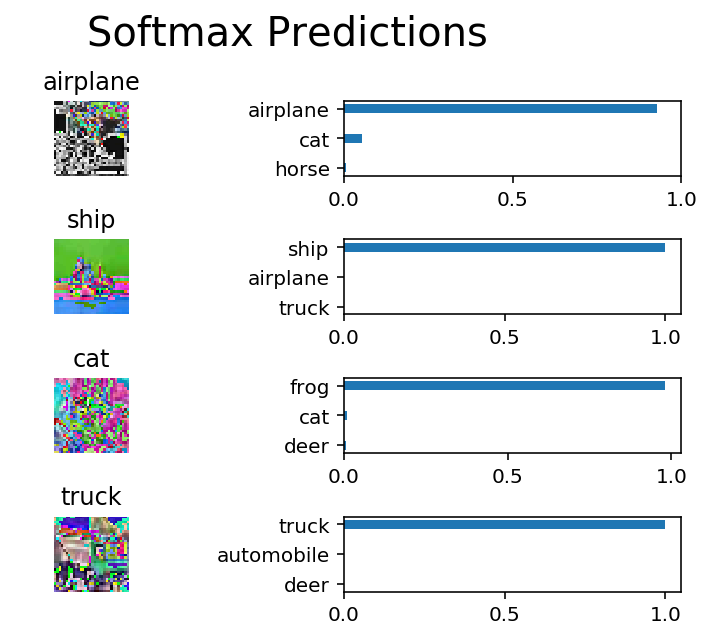

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    test_features = test_features.astype(np.float32)
    batch_mean = np.mean(test_features)
    batch_std = np.std(test_features)
    for ii in range(test_features.shape[0]):
        test_features[ii,:,:,:] = (test_features[ii,:,:,:] - batch_mean) / batch_std

    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('keep_prob_2:0')
        loaded_keep_prob_3 = loaded_graph.get_tensor_by_name('keep_prob_3:0')
        loaded_keep_prob_4 = loaded_graph.get_tensor_by_name('keep_prob_4:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_train_flag = loaded_graph.get_tensor_by_name('train_flag:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, 
                           loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                           loaded_train_flag:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                       loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                        loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                       loaded_train_flag:False})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()

2x64, 2x128, 3x256, 6x512(keep_prob:0.6), 5 max pooling layer, 300 epochs : 91.1%  
2x64, 2x128, 3x256, 6x512, 4 max pooling layer, 300 epochs : 90.9%

14 layers, Flipr(0.5), Flipud(0.2), 0.3(crop(2)), 0.3(Affine), 0.3(Gaussian(0,3)), 0.3(GaussianNoise(0,0.05*255),per channel 0.5), 0.3(Multiply(0.8,1.2), 400 epochs: 92%, 1200 epochs : 92.8%, 2000 epochs:93.1%